### Doggy

This notebook was developed to analyze the Dogs of Zurich dataset. 

In [1]:
# Standard library imports
import concurrent.futures as cf
import io
import itertools as it
import json
import math
import os
import re
import string
import time
import unicodedata
import zipfile
from typing import Callable, Optional

# Third party library imports
import cartopy.crs as ccrs
import colorcet as cc
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot
import hvplot.pandas
import lightgbm as lgb
import missingno as msno
import numpy as np
import pandas as pd
import panel as pn
import panel.widgets as pnw
import recordlinkage as rl
import seaborn as sns
import urllib.request
import xgboost as xgb
from IPython.display import clear_output
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from panel.template import FastListTemplate
from thefuzz import fuzz
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MultiLabelBinarizer,
    LabelEncoder,
)
from thefuzz import process
from wordcloud import WordCloud
from holoviews import opts, streams
from holoviews.selection import link_selections
from lightgbm import LGBMClassifier

# Local application/library specific imports
from translate_app import translate_list_to_dict

In [2]:
pn.extension(template="fast", sizing_mode="stretch_width")
pn.config.throttled = True
hv.extension("bokeh")
gv.extension("bokeh")
# don't show pandas warning
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 40)
clear_output()

In [3]:
pd.set_option("display.max_rows", 200)


def remove_accents(input_str):
    """Function to remove accents from a string.
    It takes as argument a string and returns the same string
    without accents."""
    nfkd_form = (
        unicodedata.normalize("NFKD", input_str).encode(
            "ASCII", "ignore").decode()
    )
    # return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return nfkd_form


remove_accents("résuméö")

'resumeo'

In [4]:
# get the zip file with the data from the link


data_url = (
    "https://storage.googleapis.com/mrprimetranslator_datasets/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [5]:
# Functions for getting the owner numbers roster to roster
def get_owners(df, year):
    """Function which takes in a dataframe and a year and returns a set of the owner_id"""
    return set(df[df["roster"] == year]["owner_id"])


def get_new_owners(owner_current_year, owner_previous_year):
    """Function which takes in two sets of owner_id and returns
    the set difference of the current year owners minus the previous year owners"""
    return owner_current_year.difference(owner_previous_year)


def get_returning_owners(owner_current_year, owner_previous_year):
    """Function which takes in two sets of owner_id and returns
    the intersection between the current year owners and the previous year owners"""
    return owner_current_year.intersection(owner_previous_year)


def get_left_owners(owner_current_year, owner_previous_year):
    """Function which takes in two sets of owner_id and returns
    the set difference of the previous year minus the current year"""

    return owner_previous_year.difference(owner_current_year)

In [6]:
def find_breed_match(
    input_breed: str,
    breeds_df: pd.DataFrame,
    # scoring_function: Callable[[str, str], int] = fuzz.token_set_ratio,
    scoring_functions: list[Callable[[str, str], int]],
) -> Optional[str]:
    """Find the match for the breed in the FCI breeds dataframe.
    breeds_df dataframe must have both a breed_en and alt_names column."""
    max_score = 85
    best_match = np.nan
    for index, breed_row in breeds_df.iterrows():
        alternative_names = breed_row["alt_names"]
        current_score = max(
            max(scoring_function(input_breed, alt_name)
                for scoring_function in scoring_functions)
            for alt_name in alternative_names
        )
        if current_score > max_score:
            max_score = current_score
            best_match = breed_row["breed_en"]
        if max_score == 100:
            break

    return best_match


def apply_fuzzy_matching_to_breed_column(
    dataframe: pd.DataFrame,
    breed_column: str,
    fci_df: pd.DataFrame,
    scoring_functions: list[Callable[[str, str], int]],
) -> pd.Series:
    """Apply fuzzy matching to the breed column in the dataframe."""
    return dataframe[breed_column].apply(
        lambda breed: find_breed_match(breed, fci_df, scoring_functions)
    )

In [7]:
# Shapefile for Zurich
zurich_shapefile = "../data/zurich_shape_data.zip"

# Get the path to the shapefile within the zip archive
shapefile_path = "zip://" + zurich_shapefile + "!data/stzh.adm_stadtkreise_v.shp"

# Description of zurich districts
zurich_desc_path = "../data/zurich_districts.csv"

# Read the shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# read in csv as a pandas dataframe
zurich_desc = pd.read_csv(zurich_desc_path)

# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)

In [8]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan,
           dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [9]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

We run the translation app on 
- the columns names.
- the dog breeds
- the dog colors

In [10]:
translated_words = translate_list_to_dict(
    words_set, project_id="mrprimetranslator")





translated_words

{'ALTER': 'AGE',
 'RASSENTYP': 'BREED TYPE',
 'RASSE1': 'BREED1',
 'Rassentypenliste I': 'Breed type list I',
 'Rassentypenliste II': 'Breed type list II',
 'HUNDERASSE': 'DOG BREED',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'roster': 'roster',
 'HALTER ID': 'HOLDER ID',
 'HUNDEFARBE': 'DOG COLOR',
 'Kleinwüchsig': 'Short stature',
 'RASSE2': 'BREED2',
 'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'GESCHLECHT': 'GENDER',
 'HUNDERASSENTYP': 'DOG BREED TYPE',
 'STADTQUARTIER': 'CITY QUARTER',
 'STADTKREIS': 'CITY CIRCLE',
 'GESCHLECHT HUND': 'GENDER DOG',
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED'}

In [11]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'ALTER': 'age',
 'RASSENTYP': 'breed_type',
 'RASSE1': 'breed1',
 'Rassentypenliste_I': 'breed_type_list_i',
 'Rassentypenliste_II': 'breed_type_list_ii',
 'HUNDERASSE': 'dog_breed',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'roster': 'roster',
 'HALTER_ID': 'holder_id',
 'HUNDEFARBE': 'dog_color',
 'Kleinwüchsig': 'short_stature',
 'RASSE2': 'breed2',
 'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'GESCHLECHT': 'gender',
 'HUNDERASSENTYP': 'dog_breed_type',
 'STADTQUARTIER': 'city_quarter',
 'STADTKREIS': 'city_circle',
 'GESCHLECHT_HUND': 'gender_dog',
 'RASSE2_MISCHLING': 'breed2_mixed_breed',
 'RASSE1_MISCHLING': 'breed1_mixed_breed'}

In [12]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"
# owner may be a better translation than holder
translated_headings_underscores["HALTER_ID"] = "owner_id"

In [13]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [14]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [
        dogs_of_zurich_dfs[0],
        dogs_of_zurich_dfs[1],
        dogs_of_zurich_dfs[2],
    ],
    axis=0,
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   owner_id            21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [15]:
display(dog_owner_df.sample(3))
display(dog_df.sample(3))

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
1045,84421,61-70,m,9.0,92.0,Mischling klein,NaN,NaN,NaN,K,2003,w,schwarz/braun/weiss,20151001hundehalter.csv
4576,112265,31-40,w,3.0,31.0,Mischling klein,NaN,NaN,NaN,K,2011,w,weiss/braun,20151001hundehalter.csv
622,82509,51-60,w,7.0,72.0,Rottweiler,NaN,NaN,NaN,I,2009,w,schwarz/braun,20170308hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
231,Münsterländer,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
345,Westfalenterrier,NaN,NaN,zuordnungstabellehunderassehundetyp.csv
39,Bedlington Terrier,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv


,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
5035,119569,21-30,w,11.0,111.0,Zwergspitz,NaN,Pomeranian,NaN,K,2011,w,weiss,20160307hundehalter.csv
3480,104980,41-50,m,12.0,122.0,Pinscher,NaN,Mops,NaN,K,2015,w,beige,20170308hundehalter.csv
3464,104765,71-80,w,7.0,74.0,Dackel,NaN,Yorkshire Terrier,NaN,K,2014,m,grau/beige,20170308hundehalter.csv
5276,121523,41-50,w,1.0,11.0,Labradoodle,NaN,Pudel,NaN,I,2014,m,creme,20160307hundehalter.csv
3469,104830,51-60,w,9.0,91.0,Yorkshire Terrier,Mischling,NaN,NaN,K,2008,w,dunkel gestromt,20170308hundehalter.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158,118192,61-70,w,2.0,24.0,Biewer Yorkshire Terrier,NaN,NaN,NaN,NaN,2013,m,schwarz,20151001hundehalter.csv
6785,127555,41-50,w,3.0,34.0,Pudel,NaN,NaN,NaN,NaN,2009,w,apricot,20151001hundehalter.csv
2556,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,NaN,K,1998,w,schwarz,20151001hundehalter.csv
2407,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,NaN,K,1998,w,schwarz,20160307hundehalter.csv


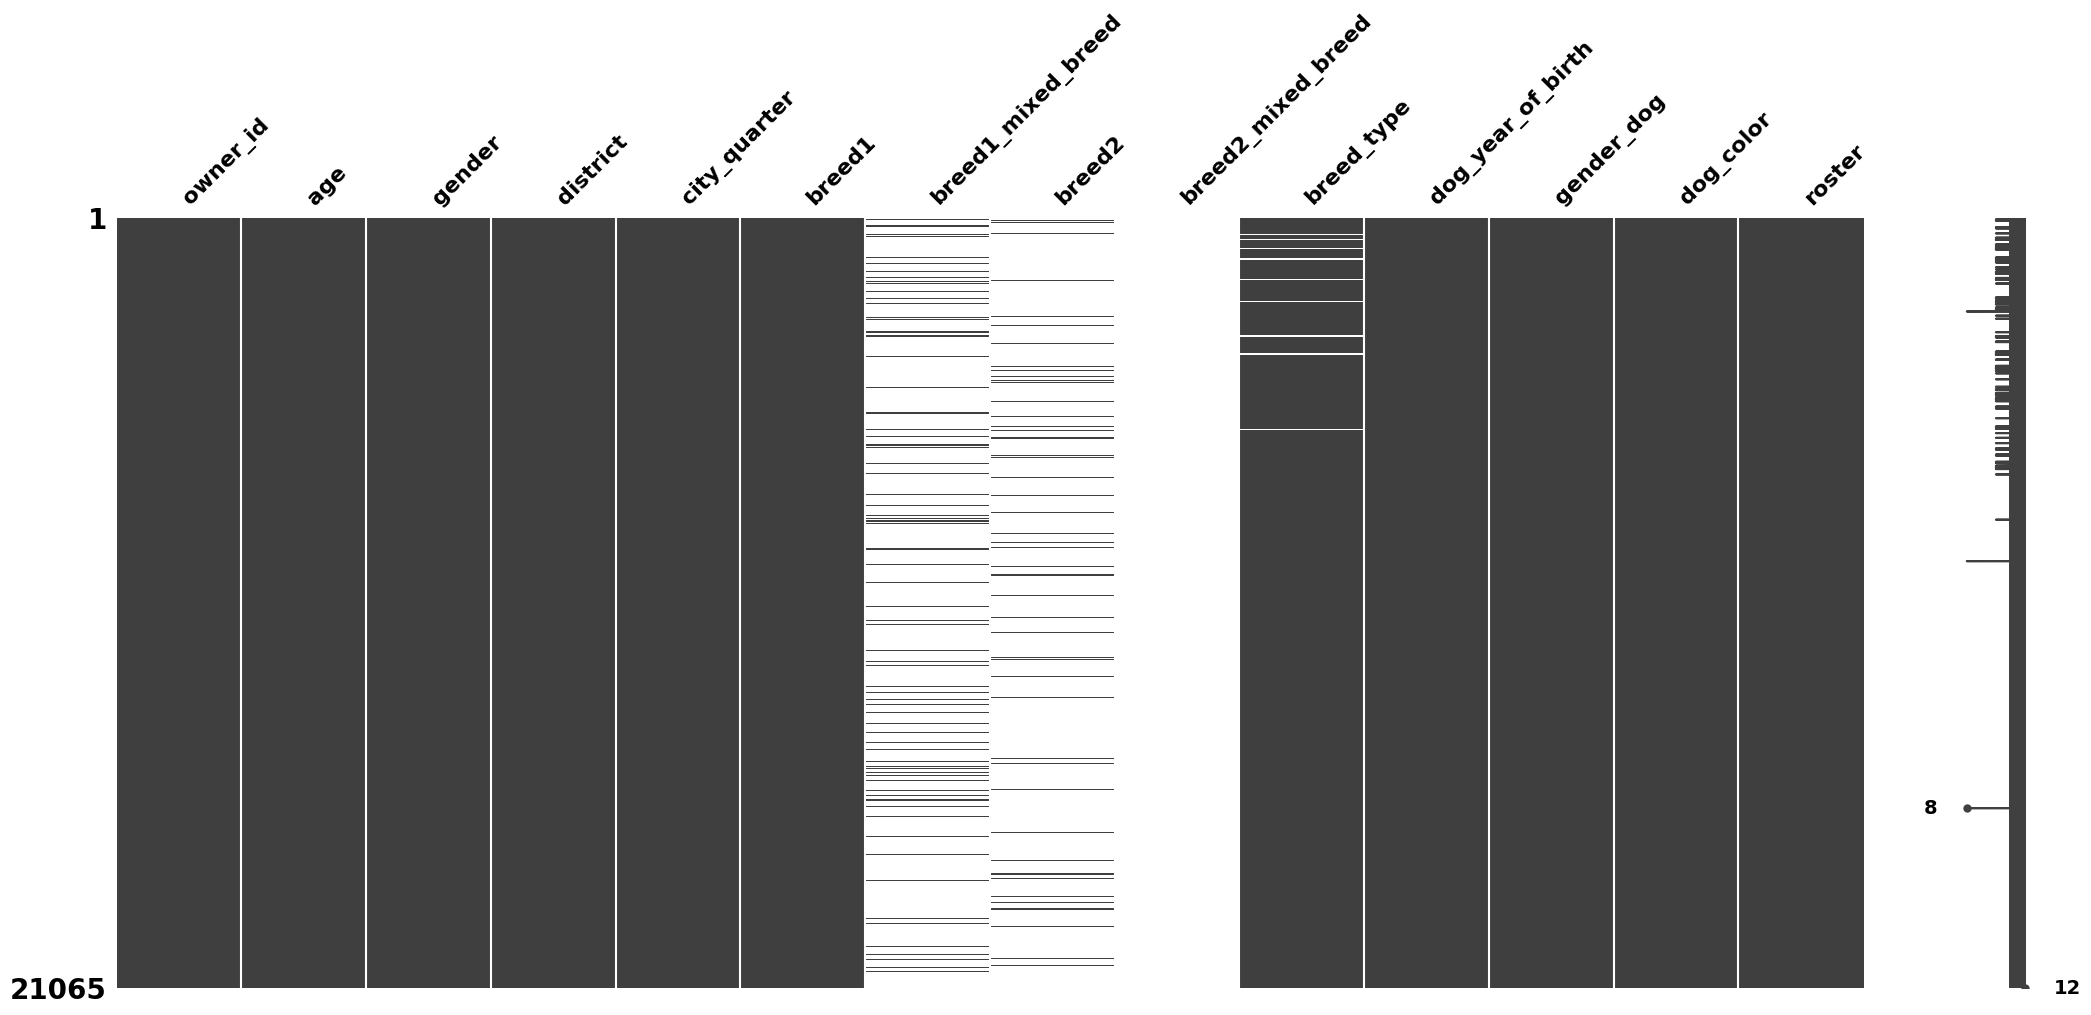

In [16]:
msno.matrix(dog_owner_df)

msno.nullity_sort(dog_owner_df, sort="descending")

In [17]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

In [18]:
"""
This code snippet performs various operations on the 'dog_owner_df' DataFrame:

1. Resets the index of the DataFrame.
2. Converts the 'district' column to a categorical data type.
3. Converts all the breed columns ('breed1', 'breed2', 'breed1_mixed_breed') to lowercase.
4. Takes the first 4 characters of the 'roster' column and converts it to an ordered categorical column.
5. Adds a column 'first_roster' that represents the first year the owner appeared in the roster.
6. Adds a column 'roster_count' that represents the number of unique rosters each owner appeared in.
7. Adds a column 'dog_count' that represents the number of dogs per owner in each roster.
8. Adds a column 'district_count' that represents the number of unique districts each owner appeared in.

9. Converts the 'owner_id' column to a string data type.
10. Adds a column 'is_male_owner' that indicates whether the owner is male or not based on the 'gender' column.
11. Adds a column 'is_male_dog' that indicates whether the dog is male or not based on the 'gender_dog' column.
"""

dog_owner_df = dog_owner_df.reset_index(drop=True)
dog_owner_df["owner_id"] = dog_owner_df["owner_id"].astype(str).str.zfill(6)
dog_owner_df["district"] = dog_owner_df["district"].astype("category")

dog_owner_df["breed1"] = dog_owner_df["breed1"].str.lower()
dog_owner_df["breed1"] = dog_owner_df["breed1"].apply(
    lambda x: remove_accents(x) if pd.notnull(x) else x
)

dog_owner_df["breed2"] = dog_owner_df["breed2"].str.lower()
dog_owner_df["breed2"] = dog_owner_df["breed2"].apply(
    lambda x: remove_accents(x) if pd.notnull(x) else x
)

dog_owner_df["breed1_mixed_breed"] = dog_owner_df["breed1_mixed_breed"].str.lower()

dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]

dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)

dog_owner_df["first_roster"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "min"
)

dog_owner_df["roster_count"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "nunique"
)

dog_owner_df["dog_count"] = dog_owner_df.groupby(["owner_id", "roster"])[
    "owner_id"
].transform("size")

dog_owner_df["district_count"] = (
    dog_owner_df[["owner_id", "district"]]
    .groupby("owner_id")["district"]
    .transform("nunique")
)

dog_owner_df["owner_id"] = dog_owner_df["owner_id"].astype(str)
dog_owner_df["is_male_owner"] = dog_owner_df["gender"].str.contains("m")
dog_owner_df["is_male_dog"] = dog_owner_df["gender_dog"].str.contains("m")
dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
20033,129353,21-30,w,11.0,115.0,labrador retriever,NaN,NaN,I,2011,m,schwarz,2017,2016,2,1,1,False,True
1437,086375,71-80,w,6.0,63.0,mops,NaN,NaN,K,2010,w,beige/schwarz,2015,2015,3,1,1,False,False
7458,081689,51-60,w,10.0,101.0,portugiesischer wasserhund,NaN,NaN,I,2007,w,schwarz,2016,2015,3,1,1,False,False


In [19]:
print(f"Number of holders: {dog_owner_df['owner_id'].nunique()}")

Number of holders: 7726


Dog with a year of birth after the roster year

In [20]:
# get the owner_id of the bad entries and observe other entries with the same owner_id
bad_entry_owner_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["owner_id"]


dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
4543,111954,41-50,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2015,2015,2,1,1,False,True
11296,111954,51-60,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2016,2015,2,1,1,False,True
5608,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2015,2015,3,1,1,True,True
12282,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2016,2015,3,1,1,True,True
18798,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2017,2015,3,1,1,True,True


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [21]:
print("Shape of dataframe before dropping bad entries")
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[dog_owner_df["owner_id"].isin(
    bad_entry_owner_id)].index

dog_owner_df.drop(bad_entry_index, inplace=True)

print("Shape of dataframe after dropping bad entries")
display(dog_owner_df.shape)


display(dog_owner_df.info())

Shape of dataframe before dropping bad entries


(21065, 19)

Shape of dataframe after dropping bad entries


(21060, 19)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21060 non-null  object  
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_roster        21060 non-null  category
 14  roster_count        21060 non-null  int64   
 15  dog_count           21060 non-null  

None

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [22]:
# get the owner_id of the bad entries
bad_entry_owner_id = dog_owner_df[dog_owner_df["dog_year_of_birth"]
                                  < 1990]["owner_id"]

# isolate entries from these owner_ids and group them by owner_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)]
    .sort_values(by="owner_id")
    .groupby("owner_id")
)

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
2659,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,1980,w,beige/schwarz,2015,2015,3,1,1,True,False
9485,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1,1,True,False
16238,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1,1,True,False
2901,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,8,w,braun,2015,2015,3,1,1,False,False
9712,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1,1,False,False
16448,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1,1,False,False
3165,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,1,w,schwarz,2015,2015,3,1,1,False,False
9966,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1,1,False,False
16689,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1,1,False,False
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,1962,m,braun/schwarz,2015,2015,3,1,1,False,True


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for the later rosters. Luckily these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it(`owner_id` 129251).

In [23]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["owner_id"].isin(bad_entry_owner_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
2659,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2015,2015,3,1,1,True,False
9485,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1,1,True,False
16238,091351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1,1,True,False
2901,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2015,2015,3,1,1,False,False
9712,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1,1,False,False
16448,094655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1,1,False,False
3165,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2015,2015,3,1,1,False,False
9966,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2016,2015,3,1,1,False,False
16689,098411,71-80,w,11.0,119.0,labrador retriever,NaN,NaN,I,2001,w,schwarz,2017,2015,3,1,1,False,False
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2015,2015,3,1,1,False,True


In [24]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(
    dog_owner_df[dog_owner_df["owner_id"] == "129251"].index
)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["owner_id"]

Series([], Name: owner_id, dtype: object)

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [25]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)


def dog_stage(age):
    """Function to categorize dog's age into stages"""
    if age <= 3:
        return "puppy"

    elif age <= 8:
        return "adult"
    elif age > 8:
        return "senior"
    else:
        return "no age given"


dog_owner_df["dog_stage"] = dog_owner_df["dog_age"].apply(dog_stage)
dog_owner_df.sample(3)
# dog_owner_df[dog_owner_df["owner_id"] == 135329]
dog_owner_df.groupby(["dog_stage", "roster"])["dog_stage"].count()

dog_stage  roster
adult      2015      2819
           2016      2865
           2017      2897
puppy      2015      1335
           2016       956
           2017      1047
senior     2015      2824
           2016      3106
           2017      3210
Name: dog_stage, dtype: int64

In [26]:
# dog_df[dog_df["dog_breed_type_short"] == "II"]
# dog_owner_df[dog_owner_df["breed_type"] == "II"].sort_values(by="owner_id")

In [27]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df["age"].fillna(0, inplace=True)
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,dog_stage
1348,085988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2015,2015,2,1,1,True,True,15,senior
2556,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2015,2015,3,1,0,True,False,18,senior
8253,085988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2016,2015,2,1,1,True,True,16,senior
9387,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2016,2015,3,1,0,True,False,19,senior
16144,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2017,2015,3,1,0,True,False,20,senior


(21059, 21)

In [28]:
# # Get owners for each year
# owner_2015 = get_owners(dog_owner_df, "2015")
# owner_2016 = get_owners(dog_owner_df, "2016")
# # owner_2017 = get_owners(dog_owner_df, "2017")

# # Print the number of initial owners in 2015
# print(f"{len(owner_2015)} initial owners in 2015")

# # Calculate and print the new, returning, and left owners for 2016
# new_2016 = get_new_owners(owner_2016, owner_2015)
# returning_2016 = get_returning_owners(owner_2016, owner_2015)
# left_2016 = get_left_owners(owner_2016, owner_2015)
# print(
#     f"{len(new_2016)} new owners in 2016, {len(returning_2016)} returning owners, and {len(left_2016)} owners left in 2016"
# )

# # Calculate and print the new, returning, and left owners for 2017
# # new_2017 = get_new_owners(owner_2017, owner_2016.union(owner_2015))
# # returning_2017 = get_returning_owners(owner_2017, owner_2016.union(owner_2015))
# # left_2017 = get_left_owners(owner_2017, owner_2016)
# # print(
# #     f"{len(new_2017)} new owners in 2017, {len(returning_2017)} returning owners, and {len(left_2017)} owners left in 2017"
# # )

# # Calculate and print the constant owners
# constant_owners = owner_2015.intersection(
#     owner_2016)  # .intersection(owner_2017)
# print(f"{len(constant_owners)} constant owners")

# # Calculate and print the gap owners
# # gap_owners = owner_2015.intersection(owner_2017).difference(owner_2016)
# # print(f"{len(gap_owners)} owners with a gap year")

In [29]:
# investigate the dog breeds of the owners which left and new owners
# dog_owner_df[dog_owner_df["owner_id"].isin(left_2016)].sort_values(by="owner_id")

In [30]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "0",
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)

In [31]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
# dog_owner_df
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

#### Missing values for breed type

In [32]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['terrier', 'pudel', 'miniature australien shepard', 'elo',
       'dogo canario', 'schwedischer vallhund', 'spaniel', 'daisy-dog',
       'deutscher jagdterrier', 'biewer yorkshire terrier'], dtype=object)

In [33]:
# Find these breeds in the dog_df and get the breed_type from there
# dog_df.drop("roster", axis=1, inplace=True)
# dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

In [34]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "owner_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(
        lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
biewer yorkshire terrier      K              20
daisy-dog                     K               2
deutscher jagdterrier         K               4
dogo canario                  I               7
elo                           I               3
miniature australien shepard  K              14
pudel                         K             216
                              I               5
schwedischer vallhund         K               2
spaniel                       K              13
terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21059 entries, 0 to 21064
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21059 non-null  object  
 1   age                 21054 non-null  category
 2   gender              21059 non-null  object  
 3   district            21054 non-null  category
 4   city_quarter        21054 non-null  float64 
 5   breed1              21059 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          21059 non-null  object  
 9   dog_year_of_birth   21059 non-null  int64   
 10  gender_dog          21059 non-null  object  
 11  dog_color           21059 non-null  object  
 12  roster              21059 non-null  category
 13  first_roster        21059 non-null  category
 14  roster_count        21059 non-null  int64   
 15  dog_count           21059 non-null  

In [35]:
missing_district_owner_id = dog_owner_df[dog_owner_df["district"].isna()][
    "owner_id"
].unique()

dog_owner_df[dog_owner_df["owner_id"].isin(missing_district_owner_id)]

# drop these missing rows with no district info
# dog_owner_df.dropna(subset=["district"], inplace=True)

# dog_owner_df.info()
# dog_owner_df[dog_owner_df["owner_id"] == "006364"]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,dog_stage,age_group,age_range
36,006364,61-70,m,NaN,NaN,appenzeller,NaN,border collie,I,2013,m,tricolor,2015,2015,2,1,0,True,True,3,puppy,61-70,60s
2556,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2015,2015,3,1,0,True,False,18,senior,NaN,NaN
7014,006364,61-70,m,NaN,NaN,appenzeller,NaN,border collie,I,2013,m,tricolor,2016,2015,2,1,0,True,True,4,adult,61-70,60s
9387,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2016,2015,3,1,0,True,False,19,senior,NaN,NaN
16144,090344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2017,2015,3,1,0,True,False,20,senior,NaN,NaN


In [36]:
dog_owner_df.loc[
    (dog_owner_df["breed1"].str.contains("appenze"))
    & (dog_owner_df["breed2"].str.contains("collie"))
    & (dog_owner_df["dog_year_of_birth"] == 2013)
]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,dog_stage,age_group,age_range
36,006364,61-70,m,NaN,NaN,appenzeller,NaN,border collie,I,2013,m,tricolor,2015,2015,2,1,0,True,True,3,puppy,61-70,60s
2148,088865,51-60,w,5.0,52.0,appenzeller,NaN,border collie,I,2013,w,tricolor,2015,2015,3,1,2,False,False,3,puppy,51-60,50s
7014,006364,61-70,m,NaN,NaN,appenzeller,NaN,border collie,I,2013,m,tricolor,2016,2015,2,1,0,True,True,4,adult,61-70,60s
8995,088865,51-60,w,5.0,52.0,appenzeller,NaN,border collie,I,2013,w,tricolor,2016,2015,3,1,2,False,False,4,adult,51-60,50s
15782,088865,51-60,w,10.0,101.0,appenzeller,NaN,border collie,I,2013,w,tricolor,2017,2015,3,1,2,False,False,5,adult,51-60,50s
20288,131077,61-70,m,5.0,52.0,appenzeller,NaN,border collie,I,2013,m,tricolor,2017,2017,1,1,1,True,True,5,adult,61-70,60s


In [37]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,dog_stage,age_group,age_range
10550,102705,41-50,w,7.0,71.0,deutscher boxer,NaN,NaN,I,2010,m,gelb,2016,2015,3,1,1,False,True,7,adult,41-50,40s
12317,121924,31-40,m,11.0,119.0,labrador retriever,NaN,NaN,I,2013,m,schwarz,2016,2015,3,1,1,True,True,4,adult,31-40,30s
18041,113709,31-40,m,8.0,83.0,english cocker spaniel,NaN,NaN,K,2012,m,schwarz,2017,2015,3,1,1,True,True,6,adult,31-40,30s


In [38]:
display(dog_owner_df["breed1_mixed_breed"].unique())
display(dog_owner_df["breed1_mixed_breed"].nunique())
display(dog_owner_df[breed_columns].describe())
dog_df["dog_breed"].unique()
# dog_owner_df["breed1"].dropna().unique().tolist()

array([nan, 'mischling'], dtype=object)

1

,breed1,breed2,breed1_mixed_breed,breed_type
count,21059,1590,1939,21059
unique,311,131,1,3
top,mischling klein,labrador retriever,mischling,K
freq,1905,121,1939,13224


array(['Affenpinscher', 'Afghane', 'Afghanischer Windhund',
       'Airedale Terrier', 'Akita Inu', 'Alano', 'Alaskan Malamute',
       'Alpenländische Dachsbracke', 'Altdeutscher Hütehund',
       'Altdeutscher Schäfer', 'American Akita', 'American Bulldog',
       'American Cocker Spaniel', 'American Pit Bull Terrier',
       'American Pitbull Terrier', 'American Staffordshire Terrier',
       'Anatolian Kangal', 'Anatolischer Hirtenhund', 'Appenzeller',
       'Appenzeller Sennenhund', 'Australian Cattle Dog',
       'Australian Shepherd', 'Australian Silky Terrier',
       'Australian Terrier', 'Australian working Kelpie',
       'Australien Kelpie', 'Azawakh', 'Barbet', 'Bardino', 'Barzoi',
       'Basenji', 'Basset', 'Basset Fauve de Bretagne',
       'Basset Griffon vendéen', 'Bayerischer Gebirgsschweisshund',
       'Beagle', 'Bearded Collie', 'Beauceron',
       'Beauceron Berge de Beauce', 'Bedlington Terrier',
       'Belgischer Schäfer', 'Bergamasker', 'Berger Picard',
    

#### Run translate app for breeds

In [39]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]
                           ].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan,
           dog_owner_df["breed1_mixed_breed"].unique())
)
breed_set = set(breed_list1 + breed_list2 + breed_list3)
breed_set = {breed.lower() for breed in breed_set}
breed_set = {remove_accents(breed) for breed in breed_set}

display(len(breed_set))
# breed_set
translations_df = pd.DataFrame()
translations_df["breed"] = list(breed_set)

# sort the breeds alphabetically
translations_df.sort_values(by="breed", inplace=True)
translations_df.shape
translations_df["breed"] = translations_df["breed"].str.lower()
translations_df["translation"] = ""
trans_dict = translate_list_to_dict(translations_df["breed"].tolist())
translations_df["translation"] = translations_df["breed"].map(trans_dict)
# translations_df.head(50)

364

In [40]:
breed_set

{'affenpinscher',
 'afghane',
 'afghanischer windhund',
 'airedale terrier',
 'akita inu',
 'alano',
 'alaskan malamute',
 'alpenlandische dachsbracke',
 'altdeutscher hutehund',
 'altdeutscher schafer',
 'american akita',
 'american bulldog',
 'american cocker spaniel',
 'american pit bull terrier',
 'american pitbull terrier',
 'american staffordshire terrier',
 'anatolian kangal',
 'anatolischer hirtenhund',
 'appenzeller',
 'appenzeller sennenhund',
 'australian cattle dog',
 'australian shepherd',
 'australian silky terrier',
 'australian terrier',
 'australian working kelpie',
 'australien kelpie',
 'azawakh',
 'barbet',
 'bardino',
 'barzoi',
 'basenji',
 'basset',
 'basset fauve de bretagne',
 'basset griffon vendeen',
 'basset hound',
 'bayerischer gebirgsschweisshund',
 'beagle',
 'bearded collie',
 'beauceron',
 'beauceron berge de beauce',
 'bedlington terrier',
 'belgischer schafer',
 'bergamasker',
 'berger blanc suisse',
 'berger de beauce',
 'berger de brie',
 'berger d

In [41]:
# get number of unique breeds in the translation column
translations_df["translation"].nunique()

356

#### Translate colors



In [42]:
# make 1 set of all the unique colors
color_set = set()

dog_colors_df = dog_owner_df["dog_color"].str.split("/", expand=True)
dog_colors_list = dog_colors_df.melt().value.unique().tolist()
dog_colors_list = [color for color in dog_colors_list if color is not None]
# dog_colors_list

# get translation for colors
dog_color_dict = translate_list_to_dict(dog_colors_list)

# dog_color_dict

In [43]:
dog_colors_en = dog_colors_df.applymap(dog_color_dict.get)
dog_colors_en.columns = ["color1", "color2", "color3"]
dog_owner_df = dog_owner_df.merge(
    dog_colors_en, left_index=True, right_index=True)

#### Get the AKC & FCI breeds saved to disk

We will use the AKC and FCI breeds list as a source of truth for the dog breed names.

In [71]:
# get the dog_breeds dataframe from the data folder
fci_breeds = pd.read_json("../data/fci_breeds.json", orient="records")
akc_breeds = pd.read_json("../data/akc_breeds.json", orient="records")
all_breeds = pd.read_json("../data/all_breeds_size.json", orient="records")

In [50]:
pattern = r"bolon"
fci_breeds[
    fci_breeds["alt_names"].apply(
        lambda names: any(re.search(pattern, str(name)) for name in names)
    )
]["alt_names"].values

array([list(['bolognese', 'bichon bolonais', 'bologneser'])], dtype=object)

Find the match first with the FCI list as it has a lot more than the AKC list. The search for a match is run onthe `alt_names` column since the breed can be referred to by any of its alternative names.

In [62]:
def match_breed(breed: str, choices: list[str], scorer: Callable[[str, str], int], cutoff: int) -> Optional[str]:
    try:
        return process.extractOne(breed, choices, scorer=scorer, score_cutoff=cutoff)[0]
    except TypeError:
        return None

    # test function
match_breed("afenpinscher",
            fci_breeds["breed_en"].tolist(), fuzz.token_set_ratio, 85)

'affenpinscher'

In [73]:
# Initialize 'alt_names' with an empty list
all_breeds["alt_names"] = [[] for _ in range(len(all_breeds))]

# Then add 'breed_de' and 'breed_en' to 'alt_names'
all_breeds["alt_names"] = all_breeds.apply(
    lambda row: [row["breed_de"], row["breed_en"]] + row["alt_names"], axis=1
)
all_breeds

,breed_de,f_height_cm,f_weight_kg,m_height_cm,m_weight_kg,breed_en,alt_names
0,affenpinscher,23 – 30 cm,4 – 6 kg,23 – 30 cm,4 – 6 kg,affenpinscher,"[affenpinscher, affenpinscher]"
1,afghanischer windhund,60 – 69 cm,26 – 34 kg,68 – 74 cm,26 – 34 kg,afghan hound,"[afghanischer windhund, afghan hound]"
2,aidi,52 – 62 cm,22 – 26 kg,52 – 62 cm,22 – 26 kg,aidi,"[aidi, aidi]"
3,airedale terrier,56 – 58 cm,18 – 20 kg,56 – 61 cm,23 – 29 kg,airedale terriers,"[airedale terrier, airedale terriers]"
4,akita inu,58 – 64 cm,25 – 36 kg,64 – 69 cm,27 – 42 kg,akita inu,"[akita inu, akita inu]"
...,...,...,...,...,...,...,...
442,zentralasiatischer owtscharka,60 – 69 cm,40 – 65 kg,65 – 68 cm,50 – 79 kg,central asian ovcharka,"[zentralasiatischer owtscharka, central asian ..."
443,zwergpinscher,25 – 30 cm,4 – 5 kg,25 – 30 cm,3 – 5 kg,miniature pinscher,"[zwergpinscher, miniature pinscher]"
444,zwergpudel,28 – 35 cm,12 – 14 kg,28 – 35 cm,12 – 14 kg,toy poodle,"[zwergpudel, toy poodle]"
445,zwergschnauzer,30 – 35 cm,5 – 8 kg,33 – 38 cm,5 – 9 kg,miniature schnauzer,"[zwergschnauzer, miniature schnauzer]"


In [84]:
# all_breeds[["breed_de", "breed_en", "alt_names"]].query(
#     "breed_en.str.contains('sh')")

In [91]:
translations_df["standard"] = np.nan
fuzz_funcs = [
    fuzz.WRatio,
    fuzz.partial_ratio,
    fuzz.token_sort_ratio,
    fuzz.token_set_ratio,
    fuzz.QRatio,
    fuzz.UQRatio,
    fuzz.UWRatio,
    fuzz.partial_token_set_ratio,
    fuzz.partial_token_sort_ratio,
    fuzz.ratio,
]
columns = ["breed", "translation"]

breeds_dfs = [
    all_breeds[["breed_en", "alt_names"]],
    fci_breeds[["breed_en", "alt_names"]],
    # akc_breeds[["breed_en", "alt_names"]],
]

for breeds_df in breeds_dfs:
    for column in columns:
        nan_mask = translations_df["standard"].isna()
        matched_values = apply_fuzzy_matching_to_breed_column(
            translations_df.loc[nan_mask], column, breeds_df, fuzz_funcs
        )
        translations_df.loc[nan_mask, "standard"] = matched_values[nan_mask]
        if translations_df["standard"].isna().sum() == 0:
            break
        print(f"Nulls left: {translations_df['standard'].isna().sum()}")

translations_df[translations_df["standard"].isna()]

Nulls left: 29
Nulls left: 17
Nulls left: 4
Nulls left: 4


,breed,translation,standard
166,durbachler,durbachler,NaN
199,mischling,hybrid,NaN
293,mischling gross,mixed breed big,NaN
118,sheltie,sheltie,NaN


In [86]:
# Create the fci_breed column with NaNs
# translations_df["standard"] = np.nan

# List of columns and fuzz functions to apply
columns = ["breed", "translation"]


fuzz_funcs = [
    fuzz.WRatio,
    fuzz.partial_ratio,
    fuzz.token_sort_ratio,
    fuzz.token_set_ratio,
    fuzz.QRatio,
    fuzz.UQRatio,
    fuzz.UWRatio,
    fuzz.partial_token_set_ratio,
    fuzz.partial_token_sort_ratio,
    fuzz.ratio,
]

# for fuzz_func in fuzz_funcs:
for column in columns:
    # Create a mask for rows where 'standard' is NaN
    nan_mask = translations_df["standard"].isna()

    # Apply the function to the entire DataFrame
    matched_values = apply_fuzzy_matching_to_breed_column(
        translations_df[nan_mask], column, fci_breeds, fuzz_funcs
    )

    # Update 'standard' only for rows where 'standard' is NaN
    translations_df.loc[nan_mask, "standard"] = matched_values[nan_mask]
    if translations_df["standard"].isna().sum() == 0:
        break
    print(f"Nulls left: {translations_df['standard'].isna().sum()}")

translations_df[translations_df["standard"].isna()].shape
translations_df.shape

Nulls left: 4
Nulls left: 4


(364, 3)

Some we know there is no matching breed for with `Mischling` as this just means mixed in german.

In [92]:
# correct the translations_df if it matched 'mischling *' to something else
translations_df.loc[
    translations_df["breed"].str.contains("mischling"), "standard"
] = "mixed breed"
translations_df.loc[
    translations_df["breed"].str.contains(r".*doodle"), "standard"
] = "mixed breed"
translations_df.loc[
    translations_df["breed"].str.contains(r"\belo\b"), "standard"
] = "elo"
translations_df.loc[translations_df["standard"].isna()].shape

(2, 3)

In [ ]:
translations_df.loc[
    translations_df["breed"].str.contains(r"bach", regex=True, case=False)
]

In [88]:
still_to_be_matched = translations_df.loc[translations_df["standard"].isna()]
still_to_be_matched

,breed,translation,standard
166,durbachler,durbachler,NaN
118,sheltie,sheltie,NaN


Follow up with the AKC list for some for which no match was found.

In [61]:
akc_breeds = akc_breeds[["breed", "alt_names"]]
akc_breeds["breed_en"] = akc_breeds["breed"].copy()
# remove None values from alt_names
akc_breeds["alt_names"] = akc_breeds["alt_names"].apply(
    lambda x: list(filter(None, x)))
akc_breeds

,breed,alt_names,breed_en
0,australian cattle dog,[australian cattle dog],australian cattle dog
1,australian shepherd,[australian shepherd],australian shepherd
2,bearded collie,"[collie, bearded collie]",bearded collie
3,beauceron,[beauceron],beauceron
4,belgian laekenois,[belgian laekenois],belgian laekenois
...,...,...,...
276,treeing tennessee brindle,[treeing tennessee brindle],treeing tennessee brindle
277,volpino italiano,[volpino italiano],volpino italiano
278,wetterhoun,[wetterhoun],wetterhoun
279,working kelpie,[working kelpie],working kelpie


In [62]:
# Apply each fuzz function to each column
for column in columns:
    # for fuzz_func in fuzz_funcs:
    # Create a mask for rows where 'standard' is NaN
    nan_mask = still_to_be_matched["standard"].isna()

    # Apply the function to the subset of DataFrame where 'standard' is NaN
    matched_values = apply_fuzzy_matching_to_breed_column(
        still_to_be_matched.loc[nan_mask], column, akc_breeds, fuzz_funcs
    )

    # Update 'standard' only for rows where 'standard' is NaN
    still_to_be_matched.loc[nan_mask, "standard"] = matched_values
    print(f"Nulls left: {still_to_be_matched['standard'].isna().sum()}")

still_to_be_matched[still_to_be_matched["standard"].isna()].shape

Nulls left: 12
Nulls left: 10


(10, 3)

In [89]:
translations_df[translations_df['standard'].isin()]

,breed,translation,standard
354,affenpinscher,affenpinscher,affenpinscher
52,afghane,Afghan,afghan hound
28,afghanischer windhund,Afghan hound,afghan hound
304,airedale terrier,airedale terrier,airedale terriers
188,akita inu,akita inu,akita inu
...,...,...,...
216,zwergpinscher,miniature pinscher,miniature pinscher
5,zwergpudel,miniature poodle,toy poodle
316,zwergrauhaardackel,miniature gray-haired dachshund,dachshund
232,zwergschnauzer,miniature schnauzer,miniature schnauzer


In [ ]:
# Keras imports
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers.schedules import ExponentialDecay

# Other imports
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from transformers import TFBertModel, BertTokenizer, TFBertForSequenceClassification, BertConfig
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
# from keras.preprocessing.sequence import pad_sequences


# from keras.preprocessing.text import Tokenizer


# from keras.layers import (
#     Conv1D,
#     GlobalMaxPooling1D,
#     Dense,
#     Embedding,
#     Dropout,
#     LSTM,
#     Bidirectional,
#     BatchNormalization,
# )


# from keras.models import Sequential


# from keras.utils import to_categorical


# from tqdm import tqdm


# import tensorflow as tf


# from sentence_transformers import SentenceTransformer


# from transformers import (
#     TFBertModel,
#     BertTokenizer,
#     TFBertForSequenceClassification,
#     BertConfig,
# )


# from sklearn.preprocessing import LabelEncoder


# from keras.callbacks import EarlyStopping


# from keras.optimizers import Adam


# from keras.losses import SparseCategoricalCrossentropy


# from keras.optimizers.schedules import ExponentialDecay

In [ ]:
# copy dataframes for easy checkpoint
translations_df_copy = translations_df.copy()
fci_breeds_copy = fci_breeds.copy()
# fci_breeds_copy["alt_names"]
# [name for sublist in fci_breeds_copy["alt_names"].values.tolist()
#  for name in sublist]

In [1]:
import tensorflow as tf

print(tf.__version__)

AttributeError: module 'tensorflow' has no attribute '__version__'

In [ ]:
from transformers import TFRobertaModel, RobertaTokenizer

# Use RoBERTa instead of BERT
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# model = TFRobertaModel.from_pretrained("roberta-base")

In [ ]:
num_classes = 356
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_config = BertConfig.from_pretrained(
    "bert-base-uncased", hidden_dropout_prob=0.5, num_labels=num_classes
)



model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    config=bert_config,
)

In [ ]:
# Create a label encoder
le = LabelEncoder()

# Get the breeds and alternative names from the FCI breeds dataframe
fci_long = fci_breeds.set_index("breed_en")["alt_names"].to_dict()
breed_en_alt_name_tuple = [
    (breed_en, alt_name)
    for (breed_en, alt_names) in fci_long.items()
    for alt_name in alt_names
]
# make the long dataframe
fci_long_df = pd.DataFrame(breed_en_alt_name_tuple, columns=["breed_en", "alt_names"])

# double data as some breeds only appear once
fci_long_df_x2 = pd.concat([fci_long_df, fci_long_df])
X = fci_long_df_x2["alt_names"]
y = fci_long_df_x2["breed_en"]

# Encode the labels
# y = le.fit_transform(y)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=628, shuffle=True, stratify=y
)

# Tokenize the training and validation features
train_inputs = tokenizer(
    X_train.tolist(), padding=True, truncation=True, return_tensors="tf"
)
val_inputs = tokenizer(
    X_val.tolist(), padding=True, truncation=True, return_tensors="tf"
)

# Convert the labels to tensors
y_train = le.fit_transform(y_train)
y_train = tf.convert_to_tensor(y_train)
y_train = tf.reshape(y_train, [-1, 1])

# only transform here
y_val = le.transform(y_val)
y_val = tf.convert_to_tensor(y_val)
y_val = tf.reshape(y_val, [-1, 1])


# Add the labels to the inputs
train_inputs = dict(train_inputs)
train_inputs["labels"] = y_train


val_inputs = dict(val_inputs)  # this is the validation data
val_inputs["labels"] = y_val

# Set learning rate parameters
initial_learning_rate = 5e-5
decay_steps = 100000
decay_rate = 0.96

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True,
)


# Define optimizer with learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)
loss = SparseCategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

In [ ]:
history = model.fit(
    train_inputs,
    epochs=3,
    batch_size=256,
    shuffle=True,
    callbacks=[early_stopping],
    validation_data=val_inputs,
)

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.__version__

In [ ]:
# Get the breeds and alternative names from the FCI breeds dataframe
fci_long = fci_breeds.set_index("breed_en")["alt_names"].to_dict()
breed_en_alt_name_tuple = [
    (breed_en, alt_name)
    for (breed_en, alt_names) in fci_long.items()
    for alt_name in alt_names
]
# make the long dataframe
fci_long_df = pd.DataFrame(breed_en_alt_name_tuple, columns=["breed_en", "alt_names"])

# Create a label encoder
le = LabelEncoder()

# Fit the encoder and transform the labels
encoded_labels = le.fit_transform(fci_long_df["breed_en"].values)

# Convert the encoded labels to a tensor
labels = tf.convert_to_tensor(encoded_labels)
labels = tf.reshape(labels, [-1, 1])

inputs = tokenizer(
    fci_long_df["alt_names"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf",
)
inputs = dict(inputs)  # Convert BatchEncoding to dictionary
inputs["labels"] = labels

# Compile the model
optimizer = Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"],
)

# Train the model
model.fit(inputs, epochs=5, batch_size=16, validation_split=0.2, shuffle=True)

In [ ]:
translations_df_copy.head(50)

In [ ]:
# Preprocess the data
translations_df_copy["breed"] = (
    translations_df_copy["breed"]
    .apply(remove_accents)
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .apply("".join)
)

# Create a dictionary where the keys are the breed_en values and the values are the alt_names lists
breed_dict = fci_breeds.set_index("breed_en")["alt_names"].to_dict()

# Create a list of tuples where each tuple contains a breed_en value and an alternative name
breed_tuples = [
    (breed, alt_name)
    for breed, alt_names in breed_dict.items()
    for alt_name in alt_names
]

y = np.array(breed_tuples)[:, 0]
X = np.array(breed_tuples)[:, 1]
Xy = pd.DataFrame(breed_tuples, columns=["target", "alt_name"])

# Preprocess the data
y = Xy["target"].values
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

Xy["alt_name"] = (
    Xy["alt_name"]
    .apply(remove_accents)
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .apply("".join)
)

X = Xy["alt_name"].apply(list)

X
f"{y.shape=}"

In [ ]:
# Initialize a tokenizer with char_level=True
tokenizer = Tokenizer(char_level=True)

# Fit the tokenizer on the X data
tokenizer.fit_on_texts(X)

# Convert to sequences of integers
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences so they all have the same length
X_padded = pad_sequences(sequences, padding="post")

# split the data into train and test sets stratified by the target
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y,
    test_size=0.2,
    random_state=628,
)

In [ ]:


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Remove blank cells
df.dropna(inplace=True)
# Define the model
model = Sequential()
model.add(
    Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=128,
        input_length=X_padded.shape[1]
    )
)
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
model.add(Conv1D(128, 5, activation="relu"))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(356, activation="softmax"))  # Output layer
# Compile the model
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
# Train the model
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=32)

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(accuracy))
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [ ]:
# model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(model.evaluate(X_test, y_test)[1], 4)}")
# Evaluate the model on the test data
evaluation_results = model.evaluate(X_test, y_test)

# Extract the test accuracy from the evaluation results
test_accuracy = evaluation_results[1]

# Print the test accuracy
print(f"Test accuracy: {round(test_accuracy, 4)}")

model.predict(X_test).argmax(axis=1)
y_test.argmax(axis=1)
results = pd.DataFrame(
    np.hstack(
        [
            y_test.argmax(axis=1).reshape(-1, 1),
            model.predict(X_test).argmax(axis=1).reshape(-1, 1),
        ]
    ),
    columns=["true", "pred"],
)

results["got_correct"] = results["true"] == results["pred"]
results["got_correct"].value_counts(normalize=True)

In [ ]:
translations_df_copy.iloc[50:100]

In [ ]:
# drop the breed_en column with the akc breed names
still_to_be_matched.drop(columns=["breed_en"], inplace=True)

# update the translations_df dataframe with the new matches in standard column
translations_df.update(still_to_be_matched)

In [ ]:
translations_df.loc[translations_df["standard"].isna()].shape

In [ ]:
# get an empty column of the dog_owner dataframe and map the fci_breed to the breed1 column

dog_owner_df = dog_owner_df.merge(
    translations_df, how="left", left_on="breed1", right_on="breed"
)
dog_owner_df.sample(3)

In [ ]:
dog_owner_df.loc[
    (dog_owner_df["breed1_mixed_breed"].notnull())
    | (dog_owner_df["breed2"].notnull())
    | (dog_owner_df["translation"].str.contains(r"mixed.*", regex=True)),
    "mixed_breed",
] = True
dog_owner_df["mixed_breed"].fillna(False, inplace=True)
dog_owner_df["is_pure_breed"] = ~dog_owner_df["mixed_breed"]
dog_owner_df["is_lone_dog"] = dog_owner_df["dog_count"] == 1

In [ ]:
# look for the count of the white swiss shepherd
dog_owner_df.standard.value_counts().head(20)

#### Correction to the Shepherds

To fix mismatch of German Shepherd breed, we transate the colors and change the rows with the WHITE SWISS SHEPHERD DOG to the correct breed of GERMAN SHEPHERD DOG. Our fuzzy algorithm mistook Shepherd to mean white Swiss Shepherd instead of German Shepherd. While all of them would not German shepherds we can safely say that the ones that were not white were not white swiss shepherds.

In [ ]:
coi = ["breed", "dog_color", "breed1", "breed2", "color1", "color2", "color3"]

german_shephard_tidying = dog_owner_df[
    dog_owner_df["breed1"].str.contains(
        r"^schäfer", case=False, regex=True, na=False)
][coi]
# check if white in any of the columns and put True in has_white column
german_shephard_tidying["has_white"] = german_shephard_tidying[coi].apply(
    lambda x: "white" in x.values, axis=1
)
# get the indexes of the rows with has_white as False
real_german_shepherd_idx = german_shephard_tidying[
    ~german_shephard_tidying["has_white"]
].index.tolist()

# change the standard column to GERMAN SHEPHERD DOG from WHITE SWISS SHEPHERD DOG
dog_owner_df.loc[real_german_shepherd_idx, "standard"] = "german shepherd dog"

In [ ]:
# the count of the white swiss shepherd should not be visible anymore and the german shepherd dog should be visible
dog_owner_df.standard.value_counts().head(20)

#### Correction to the Doodles

In [ ]:
dog_owner_df.sample().T

In [ ]:
# Create a mask for rows where the 'breed1' column contains 'doodle'
doodle_dogs_mask = dog_owner_df["breed1"].str.contains(
    "doodle", case=False, regex=True, na=False
)

# For rows where the mask is True, set the 'breed2' column to 'poodle'
dog_owner_df.loc[doodle_dogs_mask, "breed2"] = "poodle"

# For rows where the mask is True, set the 'is_pure_breed' column to False
dog_owner_df.loc[doodle_dogs_mask, "is_pure_breed"] = False

# For rows where the mask is True, set the 'mixed_breed' column to True
dog_owner_df.loc[doodle_dogs_mask, "mixed_breed"] = True

# For rows where the mask is True, set the 'standard' column to 'mixed breed large'
dog_owner_df.loc[doodle_dogs_mask, "standard"] = "mixed breed large"

# For rows where the mask is True, replace 'labradoodle' with 'labrador retriever'
# and 'goldendoodle' with 'golden retriever' in the 'breed1' column
dog_owner_df.loc[doodle_dogs_mask, "breed1"] = dog_owner_df.loc[
    doodle_dogs_mask, "breed1"
].replace(
    {"labradoodle": "labrador retriever", "goldendoodle": "golden retriever"},
    regex=True,
)

#### Add in the country of origin for the breeds

In case we need to use it later.

In [ ]:
# add the county of origin to the dog_owner_df dataframe for all the standard breeds
dog_owner_df = dog_owner_df.merge(
    fci_breeds[["breed_en", "country_of_origin"]],
    how="left",
    left_on="standard",
    right_on="breed_en",
)
dog_owner_df["standard"].fillna("unmatched", inplace=True)

In [ ]:
# capture the swiss dog breeds
swiss_breeds = fci_breeds.loc[
    fci_breeds["country_of_origin"].str.contains(r"switz", case=False, regex=True),
    "breed_en",
].to_list()

In [ ]:
swiss_breeds

In [ ]:
# create a new column is_swiss and set it to false
dog_owner_df["is_swiss"] = False


dog_owner_df.loc[
    dog_owner_df["country_of_origin"].str.contains(
        r"switz", case=False, regex=True, na=False
    ),
    "is_swiss",
] = True

dog_owner_df[dog_owner_df["is_swiss"] == True]["standard"].value_counts()

In [ ]:
pattern = re.compile(r"bichon", re.IGNORECASE)

# Use re.search to search for the pattern in the 'breed1' column
mask = dog_owner_df["breed1"].apply(lambda x: bool(re.search(pattern, str(x))))

# Use the mask to filter the dataframe
dog_owner_df[mask]["breed1"].value_counts()

# find the row in fci_breeds which has 'musterlander' as one of the names in the alt_names column
fci_breeds[
    fci_breeds["alt_names"].apply(
        lambda names: any(re.search(pattern, str(name)) for name in names)
    )
]

In [ ]:
(
    translations_df.assign(
        count=translations_df["standard"].map(
            translations_df["standard"].value_counts()
        )
    )
    .sort_values("count", ascending=False)
    .drop("count", axis=1)
    .head(10)
)

In [ ]:
dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
# dog_df.to_csv("../data/dog_df.csv", index=False)

#### EDA

In [ ]:
dog_owner_df = pd.read_csv("../data/dog_owner_df.csv")

In [ ]:
# Remmind mmyself of the columns and types
dog_owner_df.info()

In [ ]:
# Dog count each of the years
dog_owner_df.groupby(["roster"])["dog_count"].count()

In [ ]:
# map the standard unique values to a cmap for consistency
cmap = cc.glasbey_dark
# explicit mapping for the color to use for each standard breed
explicit_mapping = {
    breed: cmap[i] for i, breed in enumerate(dog_owner_df["standard"].unique())
}
my_colors = hv.Cycle(list(explicit_mapping.values()))
# colormaps for the the gender
boy_cmap = list(sns.color_palette("light:#00008b", n_colors=6).as_hex())
girl_cmap = list(sns.color_palette("light:#8b008b", n_colors=6).as_hex())

In [ ]:
# read in shape file for Zurich
gdf = gpd.read_file(shapefile_path)

# Calculate the area of each district in square kilometers
gdf["km2"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6
gdf["km2"] = gdf["km2"].round(2)

# Calculate the center coordinates of each district
gdf["center"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).centroid.to_crs(epsg=4326)

# Rename the 'knr' column to 'district'
gdf = gdf.rename(columns={"knr": "district"})

# Merge the district descriptions from 'zurich_desc' dataframe
gdf = gdf.merge(
    zurich_desc[["district", "desc", "district_name"]], how="left", on="district"
)
# drop objid column
gdf.drop(columns=["objid"], inplace=True)

# Display the updated dataframe
gdf

In [ ]:
# get the number of dogs in each of the districts for each of the rosters
dog_owner_df["district_dog_count"] = dog_owner_df.groupby(["roster", "district"])[
    "district"
].transform("size")

dog_owner_df["district_area"] = dog_owner_df["district"].map(
    gdf.set_index("district")["km2"]
)

dog_owner_df["dog_density_district"] = (
    dog_owner_df["district_dog_count"] / dog_owner_df["district_area"]
)

dog_owner_df["dog_density_district"] = dog_owner_df["dog_density_district"].astype(int)
dog_owner_df[
    [
        "district",
        "district_dog_count",
        "dog_density_district",
        "district_area",
        "roster",
    ]
].drop_duplicates().groupby(["district", "roster"])[
    "dog_density_district"
].mean().unstack().diff(
    axis=1
)
dog_owner_df

In [ ]:
gdf.to_crs(epsg=4326, inplace=True)
zurich_poly = gv.Polygons(gdf).opts(
    # projection=ccrs.GOOGLE_MERCATOR,
    tools=["hover"],
    height=500,
    width=800,
    alpha=0.5,
    fill_color="cyan",
    line_color="red",
    xaxis=None,
    yaxis=None,
    title="Zurich Districts",
    color_index=None,
    aspect="equal",
)

# add a basemap
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")

# basemap * zurich_poly
zurich_poly

In [ ]:
# Extract x and y coordinates
gdf["x"] = gdf["center"].apply(lambda point: point.x)
gdf["y"] = gdf["center"].apply(lambda point: point.y)

# Create a Labels element
district_numbers = hv.Labels(gdf, ["x", "y"], "district")
zurich_poly.data.to_crs(ccrs.GOOGLE_MERCATOR).geometry.centroid
district_numbers

In [ ]:
dog_owner_df.info()

In [ ]:
# dog_owner_df["district"] = pd.Categorical(
#     dog_owner_df["district"], ordered=False, categories=list(range(13))
# )
dog_owner_df["age_group"] = pd.Categorical(
    dog_owner_df["age_group"], ordered=True)


dog_owner_df["age_range"] = pd.Categorical(
    dog_owner_df["age_range"],
    ordered=True,
    categories=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],
)
dog_owner_df["roster"] = dog_owner_df["roster"].astype(str)


dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)
dog_owner_df["owner_id"] = dog_owner_df["owner_id"].astype(str).str.zfill(6)

In [ ]:
import re

# gap_owners
# # convert the gap_owners string to numeric
# gap_owners = [str(x) for x in gap_owners]


# dog_owner_df.loc[dog_owner_df["owner_id"].isin(
#     gap_owners)].sort_values(by="owner_id")
fci_breeds["date_of_acceptance"] = pd.to_datetime(fci_breeds["date_of_acceptance"])
fci_breeds.sort_values(by="date_of_acceptance", ascending=False)

# search the alt_names column for the list which contains the search term using regex for the search
search_term = "russian"

# Create a regex pattern to match the search term
pattern = re.compile(f".*{search_term}.*", re.IGNORECASE)

# Filter the dataframe based on the regex pattern
filtered_df = fci_breeds[
    fci_breeds["alt_names"].apply(lambda x: any(pattern.match(name) for name in x))
]
for item in dog_owner_df["standard"].unique().tolist():
    if item not in fci_breeds["breed_en"].unique().tolist():
        print(item)

In [ ]:
hv.opts.defaults(
    hv.opts.HeatMap(
        tools=["hover", "tap", "box_select"],
        active_tools=["box_zoom"],
        width=800,
        height=500,
        ylabel="",
        line_color="white",
        line_width=2,
        toolbar="above",
        selection_line_color="red",
        nonselection_alpha=0.9,
        nonselection_line_color="white",
    )
)

poly_opts = dict(
    width=800,
    height=500,
    line_width=2,
    xaxis=None,
    yaxis=None,
    aspect="equal",
    # cmap=explicit_mapping,
    # projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=500,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",
    xlabel="",
    cmap=explicit_mapping,
    show_legend=False,
    active_tools=["box_zoom"],
)

In [ ]:
# the top n small breeds in Zurich
ktopn = (
    dog_owner_df.loc[dog_owner_df["breed_type"] == "K"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
ktopn_pure = (
    dog_owner_df.loc[(dog_owner_df["breed_type"] == "K") & (dog_owner_df["is_pure_breed"])]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

# The top n big breeds in Zurich
itopn = (
    dog_owner_df[dog_owner_df["breed_type"] == "I"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
itopn_pure = (
    dog_owner_df.loc[(dog_owner_df["breed_type"] == "I") & (dog_owner_df["is_pure_breed"])]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

topn = ktopn + itopn
topn_pure = ktopn_pure + itopn_pure

##### Owner Age Distribution by Age Group

**Do older dog owners tend to have older dogs? **

FWe will investigate this graphically then in more depth.

From the voilinplot below it is clear that younger dog owners tend to have younger dogs and that the older dog owners To a lesser extreme also tend to have older dogs. Despite the slightly upwards positive correlation, each Age Group of the dog owners encompasses a wide range For dog owners in the 50s having the widest range. 

In [ ]:
dog_owner_df["age_range"] = pd.Categorical(
    dog_owner_df["age_range"],
    ordered=True,
    categories=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],
)

plt.figure(figsize=(10, 5))

# Distribution of dog owners at each age group
sns.violinplot(
    x="age_range",
    y="dog_age",
    data=dog_owner_df,
    order=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],
    color="green",
)
plt.show()

# Distribution of male and female dog owners In each district
g = sns.FacetGrid(dog_owner_df, col="is_male_dog", height=5, aspect=1.5, col_wrap=4)
g.map_dataframe(
    sns.violinplot,
    "age_range",
    "dog_age",
    hue="is_male_owner",
    split=True,
)
g.add_legend()
# add title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Dog Age | Owner Age | Male Owner bool | District")

# compare the is_male_owner and the is_male_dog columns
pd.crosstab(dog_owner_df["is_male_owner"], dog_owner_df["is_male_dog"])

Similar plot to the green one above but here there's in addition a comparison between the male and female dog owners in the violin plot.

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sub_age_prop = ("age_range", "age_group")
for age_prop, ax in zip(sub_age_prop, axs):
    sns.violinplot(
        y=age_prop,
        x="dog_age",
        data=dog_owner_df,
        inner="stick",
        split=True,
        hue="is_male_owner",
        orient="h",
        ax=ax,
    )


    ax.set_title(f"Dog age | {age_prop.title()} | Sex")

plt.tight_layout()
plt.show()

There's also a lot of variation in the correlation of the dog's age and the dog owner's age if we were to look at some of the breeds specifically

In [ ]:
# check for correlation between age and dog_age
dog_owner_df["age_range_number"] = dog_owner_df["age_range"].cat.codes


print("Correlation between age_group and dog_age for top breeds: ")

correlations = []
for breed in topn:
    for roster in ["2015", "2016", "2017"]:
        breed_roster_df = dog_owner_df[
            (dog_owner_df["standard"] == breed) & (dog_owner_df["roster"] == roster)
        ]
        correlation = breed_roster_df["age_range_number"].corr(
            breed_roster_df["dog_age"]
        )
        correlations.append((breed, roster, correlation))

correlation_df = (
    pd.DataFrame(correlations, columns=["breed", "roster", "correlation"])
    .pivot(columns="roster", index="breed", values="correlation")
    .reset_index()
)
display(correlation_df.set_index("breed").style.highlight_max(axis=0))

In [ ]:
from scipy.stats import chi2_contingency

sns.catplot(
    dog_owner_df,
    x="age_range",
    row="roster",
    kind="count",
    hue="is_male_dog",
    height=5,
    aspect=2,
)
plt.title("Owners age group count | Roster | Sex")
plt.show()

In [ ]:
cross_tab = pd.crosstab(dog_owner_df["age_range"], dog_owner_df["is_male_owner"])
cross_tab.plot(kind="bar", stacked=True)

chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
cross_tab.divide(cross_tab.sum(axis=1), axis=0).plot(
    kind="bar", stacked=True, legend=False
)
rosters = dog_owner_df["roster"].unique().tolist()
fig, axs = plt.subplots(1, len(rosters), figsize=(10, 3))
for i, roster in enumerate(rosters):
    data = dog_owner_df[dog_owner_df["roster"] == roster]
    cross_tab = pd.crosstab(dog_owner_df["age_range"], dog_owner_df["is_male_owner"])
    cross_tab_percent = cross_tab.divide(cross_tab.sum(axis=1), axis=0)
    cross_tab_percent.plot(kind="bar", stacked=True, legend=False, ax=axs[i])
    axs[i].set_title(roster)
plt.tight_layout()
plt.show()

These are the age plots which are not attached to any widgets. These are not interactive. They are three separate plots:
- a step plot with the `dog_age` distribution color coordinated by roster
- a kde plot  of the `dog_age` again
- a bar plot of the `owner_id` age.

In [ ]:
tools_opts = dict(active_tools=["box_zoom"], toolbar="above")
# bar plot of the owner age distribution
owner_age_groups_all = (
    dog_owner_df.groupby(["age", "roster"])
    .size()
    .unstack()
    .rename(columns={0: "Count"})
    .hvplot.bar(
        xlabel="",
        rot=90,
        legend=True,
        tools=["hover", "box_select"],
        title="Owners Age distribution",
    )
    .opts(**tools_opts)
)
# kde plot of the dog age distribution
dog_age_all = dog_owner_df.hvplot.kde(
    y="dog_age",
    by="roster",
    xlim=(0, 21),
    ylim=(0, 0.1),
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Dog Age Density distribution",
    muted_alpha=0.01,
).opts(**tools_opts)
# step plot of the dog age distribution
dog_age_all_step = (
    dog_owner_df.groupby(["dog_age", "roster"])
    .size()
    .hvplot.step(
        x="dog_age",
        by="roster",
        xlim=(0, 21),
        title="Dog Age distribution",
    )
    .opts(**tools_opts)
)
# panel card with the 3 plots
all_ages_card = pn.Card(
    # add spacer
    pn.Spacer(height=70),
    dog_age_all_step,
    dog_age_all,
    owner_age_groups_all,
    title="Age Distribution for ALL Dogs and Owners",
    styles={"background": "gainsboro"},
)

These are the same age distribution plots as above but these are interactive. They are controlled by widgets:
- a checkbox for `is_pure_breed` which will filter for only pure breed dogs which affects all the plots
- A single select dropdown for breed which reacts width all the plots
- An float slider for bandwidth of the kde plot only

In [ ]:
def plot_age_range_stats(df, breed, bw, is_pure_breed):
    """Function to plot the age_range stats for the breed owners and the dog age distribution"""
    if is_pure_breed:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False) & is_pure_breed == True'
        )
    else:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    # plot a step plot of the dog_age
    step = (
        breed_df.groupby(["dog_age", "roster"])
        .size()
        .unstack()
        .hvplot.step(title=f"Dog Age distribution | {breed.title()}", shared_axes=False)
    )

    # plot age_range of breed_df kde plot
    kde = breed_df.hvplot.kde(
        y="dog_age",
        by="roster",
        bandwidth=bw,
        xlim=(0, 20),
        ylim=(0, None),
        xlabel="",
        muted_alpha=0.01,
        title=f"Dog Age density distribution | {breed.title()}",
    )
    # plot age_range of breed_df bar plot

    bar = (
        breed_df.groupby(["age_range", "roster"])
        .size()
        .unstack()
        .hvplot.bar(
            rot=90,
            legend=True,
            tools=["hover", "box_select"],
            title=f"Owner Age distribution | {breed.title()} ",
            shared_axes=False,
            xlabel="",
        )
        .opts(active_tools=["box_select"])
    )
    return (step + kde + bar).cols(1)


# create widgets for the breed, bandwidth
breed_selector = pnw.Select(name="Breed", options=topn, value="french bulldog")
top_n_slider = pnw.IntSlider(name="Top N", start=1, end=30, step=1, value=10, width=200)
bandwidth_slider = pnw.FloatSlider(
    name="Bandwidth", start=0.1, end=2, step=0.1, value=0.5, width=200
)
pure_breed_checkbox = pnw.Checkbox(name="Pure Breed", value=True, width=200)
holder_gender_checkbox = pnw.Checkbox(name="Male Dog Owner", value=True, width=200)
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017"], name="Roster", width=200
)
show_labels_checkbox = pnw.Checkbox(name="Show Annotations", value=True, width=200)


# create a dynamic map

dynamic_age_plot = pn.bind(
    plot_age_range_stats,
    df=dog_owner_df,
    breed=breed_selector,
    bw=bandwidth_slider,
    is_pure_breed=pure_breed_checkbox,
)
widget_controls = pn.Row(
    pure_breed_checkbox,
    breed_selector,
    bandwidth_slider,
    styles={"background": "mintcream"},
)
dynamic_age_card = pn.Card(
    widget_controls,
    dynamic_age_plot,
    title="Age Distribution of Dog and Owners by Breeds",
    styles={"background": "mintcream"},
)

In [ ]:
# On a map of Zurich, plot the number of dogs in each district
# show any trend is clear like observed with the line plot with the French Bulldog and Chihuahua
# plot the distribution by roster

z_gdf = gdf.drop(columns=["kname"]).rename(columns={"knr": "district"})
z_gdf = z_gdf.set_index(z_gdf.district)

z_set = gv.Dataset(z_gdf)
zurich_poly = gv.Polygons(z_set).opts(
    **poly_opts, selection_color="pink", alpha=0, selection_alpha=0.5
)
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")

Breed District Polygons

This is a polygon chloropeth dynamic map which is interactive with the 
- breed selector widget (same single selector as above)
- roster slider widget.
The color of the colormap of the polygon map is specific to the selected breed. 

In addition you can interact with the map. If you click on anyone of the Polygon districts a short paragraph With the description of that neighborhood will show below the map and a word cloud from that paragraph will be shown above. 

In [ ]:
pn.state.kill_all_servers()


# get the count of the french bulldog in each district for each roster and plot it
# plot it on a dynamic map with a slider for the roster
def get_breed_count(breed, roster):
    df = dog_owner_df[
        (dog_owner_df["standard"] == breed)
        & (dog_owner_df["roster"].str.contains(roster))
    ]
    df = df.groupby("district").size().reset_index(name="count")
    df = df.set_index("district")

    breed_gdf = z_gdf.merge(df, left_index=True, right_index=True, how="left")
    breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
    breed_color = explicit_mapping[breed]
    # Start from white and go to the breed color
    breed_cmap = list(sns.color_palette(
        "light:"+breed_color, n_colors=6).as_hex())
    return gv.Polygons(breed_gdf).opts(
        **poly_opts,
        color="count",
        cmap=breed_cmap,
        clim=(0, 50),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{breed.title()} | {roster}",
    )


standard_selecter = pnw.Select(
    name="Breed", options=topn, value="french bulldog")
# create the dynamic map
breed_chloro = gv.DynamicMap(
    pn.bind(get_breed_count, breed=breed_selector, roster=roster_slider)
)

# pn.Column(standard_selecter, pn.Row(roster_slider, basemap * breed_chloro))

In [ ]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=zurich_poly)


def display_info(index):
    if not index:
        return pn.pane.Markdown("No district selected")
    else:
        selected_district = (
            zurich_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        return pn.pane.Markdown(f"#### {dnum}\n ### {dname}\n {ddesc}")


def display_wordcloud(index, breed):
    breed_color = explicit_mapping[breed]
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud))
    else:
        selected_district = (
            zurich_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = zurich_poly.iloc[index[0]].data['geometry'].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        width = maxx - minx
        height = maxy - miny

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new('1', (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test)*255,
            color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            # toolbar=None,
        )


layout = pn.Column(
    pn.bind(display_wordcloud, select_district.param.index, breed=breed_selector),
    zurich_poly * breed_chloro,
    pn.bind(display_info, select_district.param.index),
)

breed_chloro_card = pn.Card(
    roster_slider, layout, title="Chloropleth of Selected Breed"
)
# breed_chloro_card

In [ ]:
pn.state.kill_all_servers()
#  create a panel layout


pn.Row(
    dynamic_age_card,
    breed_chloro_card,
    all_ages_card,
).show()

##### HeatMaps

Here we have some heatmaps. 
- small breed heat map with the top 10 k breed type dogs and against the `districts` and also controlled by the `roster` widget
- large breed heat map with the top 10 large breed type dogs and against the `districts` and also controlled by the `roster` widget
- gender heatmap with the breeds against the `district` and is also controlled by the `roster` widget. Includes the `gender` checkbox to display only 1 gender of the dog_owners

Small breed heatmap

In [ ]:
# state the breeds that we wnat in the heatmap

small_heatmap_breeds = ktopn
# group by roster also and see how the distribution changes
small_breeds_df = dog_owner_df[dog_owner_df["standard"].isin(
    small_heatmap_breeds)]
small_heatmap_breed_count = (
    small_breeds_df.groupby(["standard", "district", "roster"])
    .size()
    .reset_index(name="size")
)
# Define a function to create a heatmap


def get_small_heatmap(roster, show_labels):
    small_df = small_heatmap_breed_count[small_heatmap_breed_count["roster"] == roster]
    small_heatmap = hv.HeatMap(small_df, ["district", "standard"], "size").redim(
        standard="small_standard"
    )
    small_heatmap.opts(
        # **heatmap_opts,
        # cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top small breeds in {roster} by district",
        clim=(0, 50),
    )
    if show_labels:
        labels = hv.Labels(small_df, ["district", "standard"], "size").opts(
            text_color="crimson"
        )
        return small_heatmap * labels
    return small_heatmap


small_dynamic_heatmap = pn.bind(
    get_small_heatmap,
    roster=roster_slider.param.value,
    show_labels=show_labels_checkbox.param.value,
)
# pn.panel(small_dynamic_heatmap)

Large Breed Heatmap

In [ ]:
large_heatmap_breeds = itopn

large_breed_df = dog_owner_df[dog_owner_df["standard"].isin(
    large_heatmap_breeds)]
large_heatmap_breed_count = (
    large_breed_df.groupby(["standard", "district", "roster"])
    .size()
    .reset_index(name="size")
)


def get_large_heatmap(roster, show_labels):
    large_df = large_heatmap_breed_count[large_heatmap_breed_count["roster"] == roster]
    large_heatmap = hv.HeatMap(large_df, ["district", "standard"], "size").redim(
        standard="large_standard"
    )
    large_heatmap.opts(
        # **heatmap_opts,
        # cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top large breeds in {roster} by district",
        clim=(
            large_heatmap_breed_count["size"].min(),
            large_heatmap_breed_count["size"].max(),
        ),
    )
    if show_labels:
        labels = hv.Labels(large_df, ["district", "standard"], "size").opts(
            text_color="crimson"
        )
        return large_heatmap * labels
    return large_heatmap


# Bind the widget to the function

large_dynamic_heatmap = pn.bind(
    get_large_heatmap,
    roster=roster_slider.param.value,
    show_labels=show_labels_checkbox.param.value,
)
# pn.panel(large_dynamic_heatmap)

# Create a Panel layout
# pn.Row(pn.Column(roster_slider, show_labels_checkbox), dynamic_heatmap)

Gender Heatmap

This is named gender heat map because one of its widgets checkbox filters for the gender of the dog owner. This could be used to be able to tell where the distribution is for only one specific dog owner gender.

In [ ]:
# Create a Tap stream linked to the HeatMap
breed_tap = streams.Tap(source=None)


@pn.depends(roster_slider.param.value, holder_gender_checkbox.param.value)
def get_gender_roster_df(roster, gender):
    return dog_owner_df.loc[
        (dog_owner_df["is_male_owner"] == gender) & (dog_owner_df["roster"] == roster)
    ]


@pn.depends(
    roster_slider.param.value,
    holder_gender_checkbox.param.value,
    top_n_slider.param.value,
)
def get_top_n_gender_breeds(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    return gender_roster_df["standard"].value_counts().head(top_n).index.tolist()


@pn.depends(
    roster_slider.param.value,
    holder_gender_checkbox.param.value,
    top_n_slider.param.value,
)
def get_gender_heatmap(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    topn_gender_breeds = get_top_n_gender_breeds(
        roster=roster, gender=gender, top_n=top_n
    )

    top_gender_breeds_df = (
        gender_roster_df.loc[gender_roster_df["standard"].isin(topn_gender_breeds)]
        .groupby(["standard", "district"])
        .size()
        .fillna(0)
        .reset_index(name="count")
    )
    sex = "Male" if gender else "Female"
    top_gender_breeds_heatmap = hv.HeatMap(
        top_gender_breeds_df, ["district", "standard"], "count"
    ).redim(standard="gender_standard")
    top_gender_breeds_heatmap.opts(
        height=(33 * top_n) + 50,
        cmap=boy_cmap if gender else girl_cmap,
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top {top_n} breeds | {roster} | {sex} Owners",
        clim=(0, 50),
    )
    breed_tap.source = top_gender_breeds_heatmap

    return top_gender_breeds_heatmap


dynamic_gender_heatmap_panel = pn.pane.HoloViews(get_gender_heatmap)

# pn.Column(
#     roster_slider,
#     holder_gender_checkbox,
#     top_n_slider,
#     dynamic_gender_heatmap_panel,
# ).show()

Chloropleth Map of the Dog owners.

This is the geographical distribution of the gender heatmap. It includes all the filters of the gender heatmap and additionally the selected breed clicked on from the gender heatmap. The color of the map is specific to the selected breed. 

In [ ]:
@pn.depends(
    breed_tap.param.x,
    breed_tap.param.y,
    roster_slider.param.value,
    holder_gender_checkbox.param.value,
)
def get_breed_chloropleth(x, y, roster, gender):
    if x is None or y is None:
        return gv.Polygons(z_gdf).opts(**poly_opts, title="Select a cell")
    else:
        data = get_gender_roster_df(roster=roster, gender=gender)
        data = data.loc[data["standard"] == y]
        data = data.groupby("district").size().reset_index(name="count")
        data = data.set_index("district")

        breed_gdf = z_gdf.merge(data, left_index=True,
                                right_index=True, how="left")
        breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
        breed_gdf.fillna(0, inplace=True)
        breed_color = explicit_mapping[y]
        breed_cmap = list(
            sns.color_palette("light:" + breed_color, n_colors=6).as_hex()
        )
        sex = "Male" if gender else "Female"

        return gv.Polygons(breed_gdf).opts(
            **poly_opts,
            color="count",
            cmap=breed_cmap,
            clim=(0, 50),
            colorbar=True,
            line_color="darkgray",
            tools=["hover", "tap", "box_select"],
            title=f"{y.title()} | {roster} | {sex} Owners",
        )


breed_chloropleth = pn.pane.HoloViews(get_breed_chloropleth)


# Combine the heatmap and the text display into a layout
layout = pn.Column(
    roster_slider,
    holder_gender_checkbox,
    top_n_slider,
    dynamic_gender_heatmap_panel,
    breed_chloropleth,
)

layout.show()

In [ ]:
# Define a Tap stream linked to the owner age group
owner_tap = streams.Tap(source=None, x=1, y="11-30")


@pn.depends(roster_slider.param.value, holder_gender_checkbox.param.value)
def get_age_heatmap(roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    data_grouped = (
        data.groupby(["age_group", "district"])["owner_id"]
        .nunique()
        .reset_index()
        .rename(columns={"owner_id": "count"})
    )
    sex = "Male" if gender else "Female"
    heatmap = hv.HeatMap(data_grouped, ["district", "age_group"], "count")

    heatmap.opts(
        # **heatmap_opts,
        cmap=boy_cmap if gender else girl_cmap,
        colorbar=True,
        active_tools=["box_zoom"],
        tools=["hover", "tap", "box_select"],
        title=f"{sex} Dog Owners | {roster} | by Age Group vs District",
    )
    owner_tap.source = heatmap
    return heatmap



age_group_panel = pn.pane.HoloViews(get_age_heatmap)

In [ ]:
import math

pn.state.kill_all_servers()
# Bar Plot which shows the top 10 breeds for each district and age group as it is selected in the heatmap

bar_plots_opts = dict(
    height=500,
    width=800,
    invert_axes=True,
    cmap=explicit_mapping,
    show_legend=False,
    xlabel="",
    fontscale=1.2,
)


@pn.depends(
    owner_tap.param.x,
    owner_tap.param.y,
    roster_slider.param.value,
    holder_gender_checkbox.param.value,
)
def update_barplot(x, y, roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    if x is None or y is None:
        bar_data = (
            data["standard"]
            .value_counts()
            .head(10)
            .rename("count")
            .reset_index()
            .rename(columns={"index": "standard"})
        )
        return hv.Bars(bar_data, kdims=["standard"], vdims="count").opts(
            **bar_plots_opts,
            color="standard",
            title=f"Top 10 Breeds",
            tools=["hover"],
            active_tools=["box_zoom"],
        )
    x = math.ceil(x - 0.5)
    bar_data = (
        data.loc[(data["district"] == x) & (
            data["age_group"] == y)]["standard"]
        .value_counts()
        .head(10)
        .reset_index()
    )
    bar_data.columns = ["standard", "count"]
    if len(bar_data) == 0:
        return hv.Bars([], "standard", "count").opts(
            **bar_plots_opts,
            title=f"No Breeds for Age-group:{y} | Districts:{x}",
            active_tools=["box_zoom"],
        )

    return hv.Bars(bar_data, "standard", "count").opts(
        **bar_plots_opts,
        color="standard",
        title=f"Top {min(10,len(bar_data))} Popular Breeds | Age-group:{y} | Districts:{x}",
    )


update_barplot_panel = pn.pane.HoloViews(update_barplot)
pn.Column(
    roster_slider,
    holder_gender_checkbox,
    age_group_panel,
    update_barplot_panel,
).show()

In [ ]:
pn.state.kill_all_servers()
# Create a Panel layout

pn.Row(
    pn.Column(roster_slider, show_labels_checkbox,
              holder_gender_checkbox, width=300),
    pn.Column(pn.panel(age_group_heatmap), update_barplot_panel),
    pn.panel(small_dynamic_heatmap),
    pn.panel(large_dynamic_heatmap),
).show()

Analytical interpretation of the data

In [ ]:
dog_owner_df.info()

In [ ]:
# dog_owner_df["age_group"].cat.codes
dog_owner_df["age_group_number"] = dog_owner_df["age_group"].cat.codes
# check for a correlation between the age_group and the dog_age
dog_owner_df["age_group_number"].corr(dog_owner_df["dog_age"])
# check for a correlation between the age_group and the dog_age but for specific breeds and for each roster


# chi Square test s
cols_for_chi = [
    "is_male_dog",
    "is_male_owner",
    "is_pure_breed",
    "breed_type",
    "roster",
    "age_group",
]
# get empty dataframe
chi_list = []
# loop through for p values
for roster in dog_owner_df["roster"].unique():
    for col in cols_for_chi:
        cross_tab = pd.crosstab(dog_owner_df[col], dog_owner_df["age_group"])
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        chi_list.append(
            {
                "roster": roster,
                "var": col,
                "chi2": chi2,
                "p": p,
                "dof": dof,
                "expected": expected,
            }
        )

chi_df = pd.DataFrame(chi_list)
# visualize the results of the Chi Test
chi_heatmap = hv.HeatMap(chi_df, kdims=["roster", "var"], vdims=["p"]).opts(
    cnorm="eq_hist", colorbar=True, title="Chi Test P-Values"
)
pn.panel(chi_heatmap).show()

print(f"Stats for the dog age for each roster: ")
display(
    dog_owner_df.groupby(["roster"])["dog_age"].apply(
        lambda x: pd.Series(
            {
                "mean": x.mean(),
                "median": x.median(),
                "std": x.std(),
                "skew": x.skew(),
                "kurt": x.kurt(),
                "size": x.size,
            }
        ).round(2)
    )
)

print(f"Stats of the dog age for each roster and owner age group: ")
dog_age_stats_by_owner_age = (
    dog_owner_df.groupby(["age", "roster"])["dog_age"]
    .apply(
        lambda x: pd.Series(
            {
                "mean": x.mean(),
                "median": x.median(),
                "std": x.std(),
                "skew": x.skew(),
                "kurt": x.kurt(),
                "size": x.size,
            }
        )
    )
    .round(2)
    .unstack()
)
display(dog_age_stats_by_owner_age)

for roster in dog_owner_df["roster"].unique():
    roster_df = dog_owner_df[dog_owner_df["roster"] == roster]
    correlation = roster_df["age"].corr(roster_df["dog_age"], method="kendall")
    print(
        f"Correlation between owner age and dog age for roster {roster}: {correlation}"
    )

print(f"Most common breeds for each age group and roster: ")
most_common_breeds = (
    dog_owner_df.groupby(["age_group", "roster"])["breed"]
    .apply(lambda x: x.value_counts().index[0])
    .unstack()
)
print(most_common_breeds)

# See which breeds tend to live the longest
print(f"Breeds with the longest lifespan: ")
breed_stats = (
    dog_owner_df.groupby(["standard", "roster"])["dog_age"]
    .apply(
        lambda x: pd.Series(
            {
                "mean": x.mean(),
                "median": x.median(),
                "std": x.std(),
                "skew": x.skew(),
                "kurt": x.kurt(),
                "size": x.size,
            }
        )
    )
    .round(2)
    .unstack()
)
breed_stats.loc[breed_stats["size"] > 20].sort_values(
    by=["mean"], ascending=False
).head(30)


# Bootstrap analysis for dog_age for each top breed
n_bootstrap_samples = 10000
bootstrap_means = pd.DataFrame()

for breed in topn:
    for roster in dog_owner_df["roster"].unique():
        breed_df = dog_owner_df[
            (dog_owner_df["standard"] == breed) & (dog_owner_df["roster"] == roster)
        ]
        bootstrap_samples = np.random.choice(
            breed_df["dog_age"], size=(n_bootstrap_samples, len(breed_df)), replace=True
        )
        bootstrap_mean = bootstrap_samples.mean(axis=1)
        bootstrap_means[f"{breed}_{roster}"] = bootstrap_mean


print(f"Bootstrap analysis for dog_age for each top breed: ")
bootstrap_means.describe().T.sort_values(by="mean", ascending=False)

# check the bootstrap again but for the swiss breeds
bootstrap_means_swiss = pd.DataFrame()
for breed in swiss_breeds:
    for roster in dog_owner_df["roster"].unique():
        breed_df = dog_owner_df[
            (dog_owner_df["standard"] == breed) & (dog_owner_df["roster"] == roster)
        ]
        bootstrap_samples = np.random.choice(
            breed_df["dog_age"], size=(n_bootstrap_samples, len(breed_df)), replace=True
        )
        bootstrap_mean_swiss = bootstrap_samples.mean(axis=1)
        bootstrap_means_swiss[f"{breed}_{roster}"] = bootstrap_mean_swiss

print(f"Bootstrap analysis for dog_age for each swiss breed: ")
bootstrap_means_swiss.describe().T.sort_values(by="mean", ascending=False)

In [ ]:
# dog_owner_df.info()
# fa_cols = [
#     "breed_type",
#     "district",
#     "roster",
#     "is_male_owner",
#     "is_male_dog",
#     "age_group",
#     "dog_age",
#     "dog_count",
#     "is_swiss",
#     "is_pure_breed",
#     "color1",
# ]
# len(fa_cols)

# fa_df = dog_owner_df[fa_cols]
# fa_df.info()
# # Example of encoding a categorical variable
# fa_df["district"] = fa_df["district"].astype("category")
# fa_df = pd.get_dummies(
#     fa_df,
#     columns=["breed_type", "district", "roster", "age_group", "color1"],
#     drop_first=True,
# )
# scaler = StandardScaler()
# fa_df = pd.DataFrame(scaler.fit_transform(fa_df), columns=fa_df.columns)
# fa_df.info()

cluster_df = dog_owner_df.copy()
# Define preprocessing for numeric columns (scale them)
numeric_features = ["dog_age", "dog_count"]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [
    "breed_type",
    "district",
    "roster",
    "age_group",
    "color1",
    "is_male_owner",
    "is_male_dog",
    "is_swiss",
    "is_pure_breed",
]
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first"))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit the pipeline to train data
pipeline.fit(cluster_df[numeric_features + categorical_features])

# Transform the dataset
cluster_data = pipeline.transform(
    cluster_df[numeric_features + categorical_features])

kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(cluster_data)

cluster_df["cluster"] = clusters

cluster_df["cluster"].value_counts()

In [ ]:
inertias = []
ks = range(2, 11)

for k in ks:
    kmeans = KMeans(n_init="auto", n_clusters=k, random_state=628)
    kmeans.fit_predict(cluster_data)
    print(f"k: {k}, Inertia: {kmeans.inertia_:.0f}")

    inertias.append(kmeans.inertia_)

# plot inertia vs k
plt.figure(figsize=(7, 7))
plt.plot(ks, inertias, "-o")
plt.xticks(ks)
plt.xlabel("Number of cluster, k")
plt.ylabel("Inertia")
plt.title("Inertia for different number of clusters")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA


# Fit PCA and get explained variance ratios
pca = PCA().fit(fa_df)
evr = pca.explained_variance_ratio_

# # Plot explained variance ratios
# plt.plot(range(1, len(evr) + 1), evr, "o-")
# plt.xlabel("Number of components")
# plt.ylabel("Explained variance ratio")
# plt.show()

# Number of components with eigenvalue > 1
n_components = sum(pca.explained_variance_ > 1)
print(f"Number of components (Kaiser Criterion): {n_components}")

# Calculate cumulative explained variance
cumulative_evr = np.cumsum(evr)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_evr) + 1), cumulative_evr, "o-")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.axhline(y=0.8, color="r", linestyle="--")  # 80% threshold
plt.show()

# Number of components for 80% variance
n_components = np.where(cumulative_evr >= 0.8)[0][0] + 1
print(f"Number of components (80% variance): {n_components}")

In [ ]:
from sklearn.decomposition import FactorAnalysis

# Initialize FactorAnalysis object
fa = FactorAnalysis(n_components=76)  # or 77 based on your previous analysis

# Fit and transform the data
fa_scores = fa.fit_transform(fa_df)
# Get factor loadings
loadings = pd.DataFrame(fa.components_, columns=fa_df.columns)

# Get unique variances
uniqueness = pd.Series(fa.noise_variance_, index=fa_df.columns)

In [ ]:
def highlight_significant_loadings(loadings_df, threshold=0.4):
    return loadings_df.style.applymap(
        lambda x: "background-color: yellow" if np.abs(x) > threshold else "")


# highlight_significant_loadings(loadings)

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer


chi2, p = calculate_bartlett_sphericity(fa_df)
print(f"Bartlett's test of sphericity: {chi2} | {p}")

# ccreate factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(fa_df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()


fa.loadings_

In [ ]:
# group by roster and district and get the number of dogs in each district
district_dog_owners = (
    dog_owner_df.groupby(["roster", "district"])["dog_count"].count().reset_index()
)
district_dog_owners.rename(columns={0: "dog_count"}, inplace=True)
# plot a bar chart of the number of dogs in each district groupby roster
# plot the bars for each roster in ta separate row in one layout using holoviews
bars = [
    district_dog_owners[district_dog_owners["roster"] == roster]
    .hvplot.bar(
        x="district",
        y="dog_count",
        title=f"Number of dogs in each district in {roster}",
        xlabel="",
        ylabel="Number of dogs",
        tools=["hover"],
        width=600,
        height=300,
    )
    .opts(
        active_tools=["box_zoom"],
    )
    for roster in district_dog_owners["roster"].unique()
]
hv.Layout(bars).cols(1)

district_dog_owners.hvplot(
    x="district",
    y="dog_count",
    by="roster",
    kind="bar",
    stacked=False,
    rot=90,
    legend=True,
    tools=["hover"],
    width=800,
    height=500,
    title="Number of dog owners in each district",
).opts(
    active_tools=["box_zoom"],
)

Top Breed counts

In [ ]:
# Group by standard and roster, and calculate the size for each group
df_breed_counts = (
    dog_owner_df[dog_owner_df["standard"].isin(topn)]
    .groupby(["standard", "roster"])
    .size()
    .reset_index(name="size")
)
df_breed_counts

In [ ]:
def get_breed_counts_df(df, breeds):
    """Function to get the breed counts for the breeds in breeds"""
    breeds = [breed.lower() for breed in breeds if breed in df["standard"].unique()]

    return (
        df.loc[df["standard"].isin(breeds)]
        .groupby(["standard", "roster"])
        .size()
        .reset_index(name="size")
    )

In [ ]:
def create_overlay(
    df,
    color_mapping=explicit_mapping,
    x_col="roster",
    y_col="size",
    color_col="standard",
):
    points = hv.Points(df, [x_col, y_col], color_col).opts(
        color="standard",
        cmap=color_mapping,
        width=800,
        height=500,
        size=8,
        legend_position="right",
        tools=["hover"],
    )

    # Create a Curve for each 'standard' and then overlay them
    curves = hv.NdOverlay(
        {
            standard: hv.Curve(data, x_col, y_col).opts(color=color_mapping[standard])
            for standard, data in df.groupby(color_col)
        }
    )
    # Overlay the points on the curves
    plot = curves * points

    return plot

In [ ]:
swiss_breed_counts_df = get_breed_counts_df(dog_owner_df, breeds=swiss_breeds)
# swiss_breed_counts_df
create_overlay(swiss_breed_counts_df)

In [ ]:
def get_breed_pct_change_df(df, breeds):
    """Function that gets the breeds pct change in the number of dogs for each roster"""
    breeds = [breed.lower()
              for breed in breeds if breed in df["standard"].unique()]
    df_breed_counts = get_breed_counts_df(df, breeds)
    df_trend_pivot = df_breed_counts.pivot(
        index="standard", columns="roster", values="size"
    )
    return (
        df_trend_pivot.pct_change(axis="columns")
        .fillna(0)
        .reset_index()
        .melt(id_vars="standard", var_name="roster", value_name="pct_change")
    )


swiss_breed_trends_df = get_breed_pct_change_df(
    dog_owner_df, breeds=swiss_breeds)
create_overlay(
    swiss_breed_trends_df,
    x_col="roster",
    y_col="pct_change",
)
# swiss_breed_trends_df

In [ ]:


# calculate the percentage change in the number of dogs for each breed
df_trend_pivot = df_breed_counts.pivot(
    index="standard", columns="roster", values="size"
)
df_breed_trend = (
    df_trend_pivot.T.pct_change().T.fillna(0).stack().reset_index(name="pct_change")
)
pct_change_overlay = create_overlay(
    df_breed_trend, explicit_mapping, x_col="roster", y_col="pct_change"
)

zero_line = hv.HLine(0).opts(
    line_dash="dashed",
    line_color="lightgray",
)
(pct_change_overlay * zero_line).opts(title="Top Breeds Percent Change YOY")

In [ ]:
df_trend_pivot_pct_change.index

In [ ]:
# Define the breeds to highlight
highlight_breeds = ["chihuahua", "french bulldog", "poodle"]
highlight_breeds = swiss_breeds
highlight_breeds = [
    highlight
    for highlight in highlight_breeds
    if highlight in list(df_trend_pivot_pct_change.index)
]

# Calculate the percentage change for each breed from year to year
df_trend_pivot_pct_change = df_trend_pivot.pct_change(axis="columns").fillna(0)


# Plot the highlighted breeds
highlight_line_plot = [
    df_trend_pivot_pct_change.loc[highlight_breed].T.hvplot(
        kind="line",
        legend="right",
        color=explicit_mapping[highlight_breed],
    )
    for highlight_breed in highlight_breeds
]

highlight_dot_plot = [
    df_trend_pivot_pct_change.loc[highlight_breed].T.hvplot.scatter(
        legend="right",
        color=explicit_mapping[highlight_breed],
    )
    for highlight_breed in highlight_breeds
]

# Plot the other breeds
other_line_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot(
    kind="line", legend="right", color="lightgray"
)
other_dot_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot.scatter(
    legend="right", color="lightgray"
)

# add in the zero like  dotted
zero_line = hv.HLine(0).opts(line_dash="dashed", line_color="lightgray")
# zero_line * line_plot_pct_change * dot_plot_pct_change
# line_plot_pct_change * dot_plot_pct_change

# Combine the plots
(
    zero_line
    * other_line_plot
    * other_dot_plot
    * hv.Overlay(highlight_line_plot)
    * hv.Overlay(highlight_dot_plot)
).opts(
    title="Percent Change in Breeds YOY",
    height=600,
    width=800,
)

In [ ]:
gdf["centroid"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).geometry.centroid.to_crs(epsg=4326)
gdf["lon"], gdf["lat"] = gdf["centroid"].x, gdf["centroid"].y
districts_pts = gdf.hvplot.points(
    x="lon",
    y="lat",
    geo=True,
    tiles="OSM",
    hover_cols=["kname"],
    alpha=0.5,
    color="skyblue",
    size=200,
    title="Zurich Districts",
    width=800,
    height=500,
    tools=["tap"],
    selection_line_color="black",
    selection_fill_color="red",
)

In [ ]:
num_dog_owners = dog_owner_df.owner_id.nunique()  # 7720
dog_owner_df[["standard", "roster", "roster_count", "owner_id"]].sort_values(
    "owner_id"
)
# owners each roster
dog_owner_df.groupby(["roster"])["owner_id"].nunique()

# french bulldog owners each roster
french_bulldog_owner_df = (
    dog_owner_df[
        dog_owner_df["standard"].str.contains(
            "french bulldog", case=False, regex=True, na=False
        )
    ]
    .groupby(["roster"])["owner_id"]
    .unique()
)

In [ ]:
def get_breed_owners_stats(dog_owner_df, breed):
    """Func for the row with the stats for the breed new, returning, and left owner numbers"""
    if breed == "all":
        breed_owner_df = dog_owner_df.copy()
    else:
        breed_owner_df = dog_owner_df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    owner_stats = {}
    for year in ["2015", "2016", "2017"]:
        breed_owner_year = get_owners(breed_owner_df, year)
        owner_stats[year] = len(breed_owner_year)

        if year != "2015":
            prev_year = str(int(year) - 1)
            breed_owner_prev_year = get_owners(breed_owner_df, prev_year)

            new_owners = get_new_owners(breed_owner_year, breed_owner_prev_year)
            returning_owners = get_returning_owners(
                breed_owner_year, breed_owner_prev_year
            )
            left_owners = get_left_owners(breed_owner_year, breed_owner_prev_year)

            owner_stats[f"new_{year}"] = len(new_owners)
            owner_stats[f"returning_{year}"] = len(returning_owners)
            owner_stats[f"left_{year}"] = len(left_owners)

    # constant owners for all 3 years
    constant_owners = (
        get_owners(breed_owner_df, "2015")
        .intersection(get_owners(breed_owner_df, "2016"))
        .intersection(get_owners(breed_owner_df, "2017"))
    )
    owner_stats["constant_owners"] = len(constant_owners)

    gap_owners = (
        get_owners(breed_owner_df, "2015")
        .intersection(get_owners(breed_owner_df, "2017"))
        .difference(get_owners(breed_owner_df, "2016"))
    )
    owner_stats["gap_owners"] = len(gap_owners)
    # change the order of columns to make it more readable
    owner_stats = {
        "breed": breed,
        "constant_owners": owner_stats["constant_owners"],
        "gap_owners": owner_stats["gap_owners"],
        "2015": owner_stats["2015"],
        "2016": owner_stats["2016"],
        "2017": owner_stats["2017"],
        "new_2016": owner_stats["new_2016"],
        "returning_2016": owner_stats["returning_2016"],
        "left_2016": owner_stats["left_2016"],
        "new_2017": owner_stats["new_2017"],
        "returning_2017": owner_stats["returning_2017"],
        "left_2017": owner_stats["left_2017"],
    }

    return pd.DataFrame(owner_stats, index=[0])


# Usage:
french_bulldog_stats = get_breed_owners_stats(dog_owner_df, "french bulldog")
get_breed_owners_stats(dog_owner_df, "all")

# breed_owner_stats_list = [
#     get_breed_owners_stats(dog_owner_df, breed) for breed in top_breeds
# ]

In [ ]:
owner_2015 = get_owners(dog_owner_df, "2015")
owner_2016 = get_owners(dog_owner_df, "2016")
owner_2017 = get_owners(dog_owner_df, "2017")
left_2016 = get_left_owners(owner_2016, owner_2015)
left_2017 = get_left_owners(owner_2017, owner_2016)
(
    dog_owner_df.loc[dog_owner_df["owner_id"].isin(left_2016)]["age"]
    .value_counts()
    .sort_index()
    .hvplot.bar()
    + dog_owner_df.loc[dog_owner_df["owner_id"].isin(left_2017)]["age"]
    .value_counts()
    .sort_index()
    .hvplot.bar()
).cols(1)

Breed roster counts stats

In [ ]:
# Owner ins and outs for the top 10 breeds
pd.concat(
    [get_breed_owners_stats(dog_owner_df, breed) for breed in ktopn], axis=0
).reset_index(drop=True)
pd.concat(
    [get_breed_owners_stats(dog_owner_df, breed) for breed in topn], axis=0
).reset_index(drop=True)

# breed_ii_owners = set(
#     dog_owner_df.loc[(dog_owner_df["breed_type"] == "II")]["owner_id"].tolist()
# )
# dog_owner_df.loc[dog_owner_df["owner_id"].isin(breed_ii_owners)].sort_values(
#     "owner_id"
# )

In [ ]:
# dog_owner_df[(dog_owner_df["breed_type"] == "II")].groupby(
#     ["standard", "roster"]
# ).size().unstack().sort_values(by="2017", ascending=False)

In [ ]:
# Define the widget
roster_slider = pnw.DiscreteSlider(options=["2015", "2016", "2017"], name="Roster")
district_slider = pnw.IntSlider(name="District", value=1, start=1, end=12)


selection_stream = streams.Selection1D(source=zurich_poly)


def get_barplot(roster, district):
    # Get the data for the selected district and roster
    df = (
        dog_owner_df[
            (dog_owner_df["district"] == district) & (dog_owner_df["roster"] == roster)
        ]
        .groupby("standard")
        .size()
        .sort_values(ascending=False)
        .reset_index(name="count")
        .head()
    )

    # Create the barplot
    barplot = hv.Bars(df, "standard", "count").opts(
        **bar_opts,
        color="standard",
        title=f"Top 5 breeds in {roster} in district {district}",
    )
    lables = hv.Labels(df, ["standard", "count"], "standard").opts(
        text_font_size="14pt", text_color="white", text_align="right"
    )
    return barplot


bar_panel = pn.panel(
    pn.bind(get_barplot, roster=roster_slider, district=district_slider)
)

In [ ]:
bar_panel

##### Networkx


In [ ]:
# gap owners
import matplotlib.pyplot as plt
from networkx.algorithms import community
import networkx as nx

In [ ]:
# movers


def get_district_targets(df, roster_year, target_column="district"):
    """Return the values for the target column for the given roster year with owner_id"""
    return df[df["roster"] == roster_year][
        ["owner_id", target_column]
    ].drop_duplicates()


# district_count_df = dog_owner_df[["owner_id", "district", "roster"]]

# district_count_pivot = (
#     district_count_df.drop_duplicates()
#     .pivot(columns="roster", values="district", index="owner_id")
#     .reset_index()
# )

# district_count_pivot["movers"] = district_count_pivot.apply(
#     lambda x: len(set(v for v in x[1:3] if pd.notnull(v))) > 1, axis=1
# )

# district_count_pivot["mover_count"] = district_count_pivot.apply(
#     lambda x: len(set(v for v in x[1:3] if pd.notnull(v))), axis=1
# ).astype(str)


# moves_df = (
#     district_count_pivot.loc[district_count_pivot["movers"]]
#     .fillna(0)
#     .drop(columns=["movers"])
# )

# movers_df = district_count_pivot.fillna(0).rename(
#     columns={
#         "2015": "holder_district_2015",
#         "2016": "holder_district_2016",
#         # "2017": "holder_district_2017",
#     }
# )
# movers_df

get_district_targets(dog_owner_df, "2015", "2016", "2017")

In [ ]:
# create dict with histogram opts
hist_opts = dict(
    width=300, height=300, framewise=True, axiswise=True, active_tools=["box_zoom"]
)


# Function to create a graph from a DataFrame
def create_graph(df, source, target):
    return nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=True)


# Function to calculate centralities
def calculate_centralities(graph, centralities):
    # Define the states dictionary
    states = {node: 1 for node in graph.nodes}

    results = {}
    for name, function in centralities.items():
        if name == "Percolation":
            # Pass the states dictionary to the percolation_centrality function
            results[name] = function(graph, states=states)
        else:
            results[name] = function(graph)
    return results


# Function to plot centralities
def plot_centralities(centralities):
    plots = [
        hv.Histogram(
            np.histogram(list(centrality.values()), bins=8),
            kdims="Centrality",
            vdims="Frequency",
        ).opts(title=name, **hist_opts)
        for name, centrality in centralities.items()
    ]
    return hv.Layout(plots)


# Function to calculate communities
def calculate_communities(graph):
    return list(community.greedy_modularity_communities(graph))


# Define the centralities
centralities = {
    "Degree": nx.degree_centrality,
    "Betweenness": nx.betweenness_centrality,
    "Closeness": nx.closeness_centrality,
    "Eigenvector": nx.eigenvector_centrality,
    "Harmonic": nx.harmonic_centrality,
    "Percolation": nx.percolation_centrality,
    "PageRank": nx.pagerank,
}
moves_graph_2015_2016 = create_graph(moves_df, "2015", "2016")
# moves_graph_2016_2017 = create_graph(moves_df, "2016", "2017")

# combined_graph = nx.compose(moves_graph_2015_2016, moves_graph_2016_2017)
combined_graph = moves_graph_2015_2016

# Calculate the communities
communities = calculate_communities(combined_graph)
print(f"Number of communities: {len(communities)}")
print(f"Communities: {communities}")
# Calculate the centralities
calculated_centralities = calculate_centralities(combined_graph, centralities)

# Plot the centralities
plot_centralities(calculated_centralities)

In [ ]:
# for node, attributes in moves_graph_2015_2017.nodes(data=True):
#     print(f"Node: {node} Attributes: {attributes}")

# gdf.sort_values(by="district", inplace=True)
# gdf["desc"].iloc[0]

combined_graph.edges
# dog_owner_df

In [ ]:
dog_owner_df.info()

In [ ]:


def process_attribute(df, attr_col, rosters=("2015", "2016")):
    """pivots on index owner_id and columns roster and values attr_col"""

    dataframe = df[["roster", attr_col, "owner_id"]]
    dataframe = dataframe.loc[dataframe["roster"].isin(rosters)]
    df_pivot = (
        dataframe.drop_duplicates()
        .pivot(columns="roster", values=attr_col, index="owner_id")
        .reset_index()
    )
    for col in df_pivot.columns:
        if df_pivot[col].dtype.name == "category":
            df_pivot[col] = df_pivot[col].cat.add_categories([0])
            # if it is numeric with np.number fillna 0
        elif df_pivot[col].dtype.name in ["int64", "float64"]:
            df_pivot[col] = df_pivot[col].fillna(0)
        else:
            df_pivot[col] = df_pivot[col].fillna("")

    df_pivot = df_pivot.fillna(0)

    df_pivot = df_pivot.rename(
        columns={
            str(roster): f"{attr_col}_{roster}"
            for roster in rosters
            if str(roster) in df_pivot.columns.values
        }
    )

    return df_pivot


col_dict = {
    "dog_age": ["mean", "max", "min"],
    "dog_count": ["mean"],
    'dog_density_district': ["mean", 'max', 'min'],
    "standard": [("owner", lambda x: tuple(set(x)))],
    "age_group": [("owner", lambda x: tuple(set(x)))],
    "breed_type": [("owner", lambda x: tuple(set(x)))],
    # "district": [("owner", lambda x: tuple(x))],
}


def process_multi_attribute(df, rosters=("2015", "2016"), attr_dict=col_dict):
    dataframe = df[list(attr_dict.keys()) + ["owner_id", "roster"]].copy()
    filtered_df = dataframe.loc[dataframe["roster"].isin(rosters)]
    filtered_df["roster"] = filtered_df["roster"].cat.remove_unused_categories()
    df_grouped = (
        filtered_df.groupby(["roster", "owner_id"]).agg(
            attr_dict).reset_index()
    )
    df_grouped.columns = ["_".join(col).strip("_")
                          for col in df_grouped.columns.values]

    return df_grouped


def ready_data(df, rosters=("2015", "2016"), attr_dict=col_dict):
    """Takes in a dataframe and returns X and y ready for modeling"""
    X = process_multi_attribute(
        df, rosters=rosters, attr_dict=attr_dict).dropna()
    X_set = pd.concat(
        [
            process_attribute(X, col, rosters=(*rosters[:-1],))
            for col in X.columns
            if col not in ["owner_id", "roster"]
        ],
        axis=1,
    )

    # Drop duplicate columns
    X_set = X_set.loc[:, ~X_set.columns.duplicated()].set_index("owner_id")

    # get the targets
    targets = process_attribute(
        df, "district", rosters=rosters).set_index("owner_id")

    X_set = X_set.merge(targets, how="outer",
                        left_index=True, right_index=True)

    y = X_set.iloc[:, -1:]
    X_set.drop(columns=y.columns, inplace=True)

    for col in X_set.columns:
        if X_set[col].dtype.name == "category":
            # X_set[col] = X_set[col].cat.add_categories([0])  # Remove this line
            pass
        elif X_set[col].dtype.name in ["int64", "float64"]:
            X_set[col] = X_set[col].fillna(0)
        else:
            X_set[col] = X_set[col].fillna("")

    y = y.values.ravel().astype(int)

    return X_set, y


X_set, y = ready_data(dog_owner_df, ("2015", "2016"))
print(f"X_set shape: {X_set.shape} | y shape: {y.shape}")

In [ ]:
display(X_set)
columns_to_scale = []
columns_to_scale = [
    col for col in X_set.columns if pd.api.types.is_numeric_dtype(X_set[col]) and not col.startswith("district_")
]
columns_to_encode = []
columns_to_encode = [
    col
    for col in X_set.columns
    if col not in columns_to_scale and not col.startswith("district_")
]
district_cols = []
district_cols = [col for col in X_set.columns if col.startswith("district_")]

print(
    f"Columns to scale:\n {columns_to_scale},\n Columns to encode:\n {columns_to_encode},\n District columns:\n {district_cols}"
)

In [ ]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
for column in district_cols:
    # Convert the district column to string
    X_set[column] = X_set[column].astype(str)
    encoded_features = ohe.fit_transform(X_set[column].values.reshape(-1, 1))
    df_encoded_features = pd.DataFrame(
        encoded_features, columns=ohe.categories_[0], index=X_set.index
    )
    X_set = pd.concat([X_set.drop(columns=[column]),
                      df_encoded_features], axis=1)

mlb = MultiLabelBinarizer()
for column in columns_to_encode:
    encoded_features = mlb.fit_transform(X_set[column])
    df_encoded_features = pd.DataFrame(
        encoded_features, columns=mlb.classes_, index=X_set.index
    )
    X_set = pd.concat([X_set.drop(columns=[column]),
                      df_encoded_features], axis=1)



X_train, X_test, y_train, y_test = train_test_split(
    X_set, y, stratify=y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

display(X_train.head())
rf_model = RandomForestClassifier(
    n_estimators=1000, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(
    f"ROC AUC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')}"
)


print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

In [ ]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """

    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X: pd.DataFrame, y=None):
        for i in range(X.shape[1]):  # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:, i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X: pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError("Please fit the transformer first.")
        if self.n_columns != X.shape[1]:
            raise ValueError(
                f"The fit transformer deals with {self.n_columns} columns "
                f"while the input has {X.shape[1]}."
            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:, i]))

        result = np.concatenate(result, axis=1)
        return result

    def get_feature_names(self, input_features=None):
        """Return feature names for output features"""
        feature_names = []
        for i in range(self.n_columns):
            # Get the column name
            column_name = input_features[i] if input_features else f"column_{i}"
            # Get the classes for this column
            classes = self.classes_[i]
            # Combine the column name and class names to create feature names
            column_feature_names = [f"{column_name}_{cls}" for cls in classes]
            # Append the feature names to the list
            feature_names.extend(column_feature_names)
        return feature_names

In [ ]:
class PriorYearModel(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None):
        self.encoder = encoder

    def fit(self, X: pd.DataFrame, y=None):

        # Assume 'district_2015' is a column in X

        self.prior_year = np.array(X)[:, -1].copy()

        # Store the unique classes and number of unique classes in y

        self.classes_ = np.unique(y)

        self.n_classes_ = len(self.classes_)
        return self


    def predict(self, X):
        # Return the prior year data for the given instances


        return self.encoder.transform(np.array(X)[:, -1])


    def predict_proba(self, X):
        # Create an array with shape (n_samples, n_classes)


        proba = np.zeros((X.shape[0], self.n_classes_))

        # Get the predicted class for each sample

        predictions = self.predict(X)

        # Convert class labels to indices

        predictions_indices = np.array(



            [np.where(self.classes_ == pred)[0][0] for pred in predictions]
        )


        # Set the probability of the predicted class to 1 for each sample

        for i, prediction_index in enumerate(predictions_indices):

            proba[i, prediction_index] = 1

        return proba

In [ ]:
y.shape

In [ ]:
# get the data ready for modeling
X_set, y = ready_data(dog_owner_df, ("2015", "2016", "2017"))

encoder = LabelEncoder()
y = encoder.fit_transform(y.ravel())

X_train, X_test, y_train, y_test = train_test_split(
    X_set, y, stratify=y, test_size=0.2, random_state=42
)
# list for the results
results = []

In [ ]:
X_train.shape, y_train.shape

In [ ]:
# display(X_set)
columns_to_scale = []
columns_to_scale = [
    col
    for col in X_set.columns
    if pd.api.types.is_numeric_dtype(X_set[col]) and not col.startswith("district_")
]
columns_to_encode = []
columns_to_encode = [
    col
    for col in X_set.columns
    if col not in columns_to_scale and not col.startswith("district_")
]
district_cols = []
district_cols = [col for col in X_set.columns if col.startswith("district_")]

print(
    f"Columns to scale:\n {columns_to_scale},\n Columns to encode:\n {columns_to_encode},\n District columns:\n {district_cols}"
)

In [ ]:
# Define the numeric transformer pipeline
numeric_transformer = StandardScaler(with_mean=False)
# Define the column transformer
col_transformer = ColumnTransformer(
    [
        # Apply MultiHotEncoder to columns_to_encode
        ("multi-hot", MultiHotEncoder(), columns_to_encode),
        ("one-hot", OneHotEncoder(handle_unknown="ignore"), district_cols),
        ("std_scale", numeric_transformer, columns_to_scale),
    ],
    remainder="passthrough",  # Passthrough the remaining columns
)


# Define the models
models = [
    ("rf", RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
    ("lgbm", LGBMClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
    # ("log_reg", LogisticRegression(multi_class="multinomial", n_jobs=-1)),  # Logistic Regression
    # ("xgb", xgb.XGBClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),  # XGBoost Classifier
    # ("gb", GradientBoostingClassifier(n_estimators=1000, random_state=42)),  # Gradient Boosting Classifier
]

In [ ]:
# Create an instance of the PriorYearModel
prior_year_model = PriorYearModel(encoder)
start = time.time()
# Train the PriorYearModel
prior_year_model.fit(X_train, y_train)

# Test the PriorYearModel
y_pred = prior_year_model.predict(X_test)
end = time.time()
elapsed_time = end - start

# Calculate the metrics for the PriorYearModel
prior_year_results = {
    "name": "prior_year_model",
    "accuracy": accuracy_score(y_test, y_pred).round(3),
    "f1_score": f1_score(y_test, y_pred, average="macro").round(3),
    "roc_auc_score": roc_auc_score(
        y_test, prior_year_model.predict_proba(X_test), multi_class="ovo"
    ).round(3),
    "time": elapsed_time,
}
results.append(prior_year_results)
# print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(f" Classification Report: \n{classification_report(y_test, y_pred)}")
# Print the results
print(prior_year_results)

for i, (name, model) in enumerate(models):
    print(f"Training model {i+2}/{len(models)+1}: {name}")
    start_time = time.time()

    pipeline = Pipeline(
        steps=[
            ("multi-hot", col_transformer),
            ("scaler", numeric_transformer),
            ("classifier", model),
        ]
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    end_time = time.time()
    elapsed_time = end_time - start_time

    results.append(
        {
            "name": name,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred, average="macro"),
            "roc_auc_score": roc_auc_score(
                y_test, pipeline.predict_proba(X_test), multi_class="ovo"
            ),
            "time": elapsed_time,
        }
    )
    print(results[-1])

    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
    print("--------------------------------------------------------------")


pd.DataFrame(results)

In [ ]:
# Get the column transformer from the pipeline
column_transformer = pipeline.named_steps["multi-hot"]

# Initialize an empty list to hold the feature names
feature_names = []

# Loop over each transformer in the column transformer
for _, transformer, columns in column_transformer.transformers_:
    print(f"Processing columns: {columns}")

    # Check if the transformer is an instance of MultiHotEncoder
    if isinstance(transformer, MultiHotEncoder):
        print(f"Classes: {transformer.classes_}")

    # Check if the transformer has a get_feature_names_out method
    if hasattr(transformer, "get_feature_names_out"):
        # Get the feature names from the transformer
        transformer_feature_names = transformer.get_feature_names_out(
            input_features=columns
        )
    else:
        # If the transformer doesn't have a get_feature_names_out method, use the column names as feature names
        transformer_feature_names = columns

    print(f"Feature names: {transformer_feature_names}")

    # Append the feature names to the list
    feature_names.extend(transformer_feature_names)

print(f"Total number of features: {len(feature_names)}")

In [ ]:
import shap

# Fit the model
pipeline.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(
    pipeline.named_steps["classifier"],
)

# Apply all transformation steps in the pipeline
X_train_transformed = pipeline.named_steps["multi-hot"].transform(X_train)
X_train_transformed = pipeline.named_steps["scaler"].transform(
    X_train_transformed)

# Compute SHAP values
shap_values = explainer(X_train_transformed)

# Plot the SHAP values of the first prediction
# shap.plots.waterfall(shap_values[0, 0])

In [ ]:
shap.plots.waterfall(shap_values[0, :, 0])
shap.summary_plot(shap_values[:, :, 0], X_train_transformed)
shap.plots.beeswarm(shap_values[:, :, 0], max_display=10)

In [ ]:
# Define the model


model = LGBMClassifier(objective="multiclass", random_state=42)

pipeline = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("scaler", numeric_transformer),
        ("classifier", model),
    ]
)


# Define the parameter grid
param_distributions = {
    "classifier__n_estimators": [500, 1000],
    "classifier__learning_rate": [0.01, 0.1, 0.5, 1.0],
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__class_weight": ["balanced", None],
    # add more parameters to tune
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=10,
    cv=4,
    scoring="f1_macro",
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# plot the feature importance
# lgb.plot_importance(best_model["classifier"], figsize=(12, 8))

# Evaluate the model


y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):0.3f}")
print(
    f"ROC AUC Score: {roc_auc_score(y_test, random_search.predict_proba(X_test), multi_class='ovo'):.3f}"
)

In [ ]:
import shap

# Fit the model
rf_model.fit(X_train, y_train)


# Create a SHAP explainer
explainer = shap.Explainer(rf_model)

# Compute SHAP values
shap_values = explainer(X_train)

# Plot the SHAP values of the first prediction
shap.plots.waterfall(shap_values[0])

# Evaluate the model
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):0.3f}")
print(
    f"ROC AUC Score: {roc_auc_score(y_test, random_search.predict_proba(X_test), multi_class='ovo'):.3f}"
)